# 0 Early preparations

In [ ]:
## connect with drive
from google.colab import drive
drive.mount('/content/drive')

## install libraries
!pip install torch torchvision numpy matplotlib opencv-python
!pip install timm


Mounted at /content/drive


In [ ]:
## unzip Spair71k
import tarfile
import os
data_zip_path = '/content/drive/MyDrive/Project_Semantic/SPair-71k/SPair-71k.tar.gz'
unzip_path = '/content/spair_data'

# start unzip
# creat a new folder to save data
if not os.path.exists(unzip_path):
    os.makedirs(unzip_path)

with tarfile.open(data_zip_path, 'r:gz') as tar_ref:
        tar_ref.extractall(unzip_path)

print("unzip complete")


/tmp/ipython-input-4276553787.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(unzip_path)


unzip complete


100 images of cat


Text(0.5, 1.0, 'Target:2008_005252.jpg')

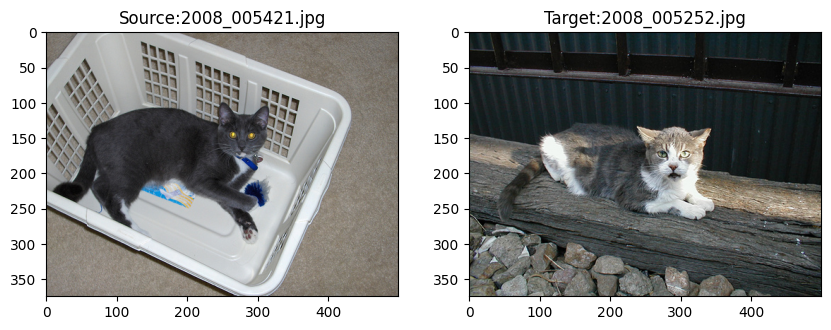

In [ ]:
## test the data with DINOv2 to know if it's available
import matplotlib.pyplot as plt
from PIL import Image
import os

# set the root path of the images
base_path = '/content/spair_data/SPair-71k/JPEGImages'
category = 'cat'
image_folder = os.path.join(base_path, category)


# get the numbers of all images from categoyr selaected
all_images = os.listdir(image_folder)
print(f"{len(all_images)} images of {category}")

# choose two images
img_name_1 = all_images[98] # source image
img_name_2 = all_images[45] # target image

# open images
image_source = Image.open(os.path.join(image_folder, img_name_1)).convert("RGB")
image_target = Image.open(os.path.join(image_folder, img_name_2)).convert("RGB")

# show them
fig,axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_source)
axes[0].set_title(f"Source:{img_name_1}")

axes[1].imshow(image_target)
axes[1].set_title(f"Target:{img_name_2}")

# 1 Test DINOv2

In [ ]:
## extract dense features
import torch
import torchvision.transforms as T

# define the rules for image preprocessing
transform = T.Compose([
    T.Resize((224, 224)),     # resize image to 224x224
    T.ToTensor(),          # convert image to numerical tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize colors
])

# process those images before
img_tensor_1 = transform(image_source).unsqueeze(0)
img_tensor_2 = transform(image_target).unsqueeze(0)

print(f"Image1 shape: {img_tensor_1.shape}")  # results should be [1, 3, 224, 224]
                         # [number of photos, RGB, size, size]


# load DINOv2 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model.to(device)
model.eval() # Evaluation mode

print("Model loaded")


# Start extracting features
with torch.no_grad(): # dont calculate the gradiens

    img_tensor_1 = img_tensor_1.to(device)# move processed images to gpu
    img_tensor_2 = img_tensor_2.to(device)

    features_1 = model.forward_features(img_tensor_1)["x_norm_patchtokens"] # spit out features
    features_2 = model.forward_features(img_tensor_2)["x_norm_patchtokens"]

print(f"Source shape: {features_1.shape}")
print(f"Target shape: {features_2.shape}")


Image1 shape: torch.Size([1, 3, 224, 224])


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded
Source shape: torch.Size([1, 256, 768])
Target shape: torch.Size([1, 256, 768])


Source point 104 matches best with Target point 120
Score: 0.6695


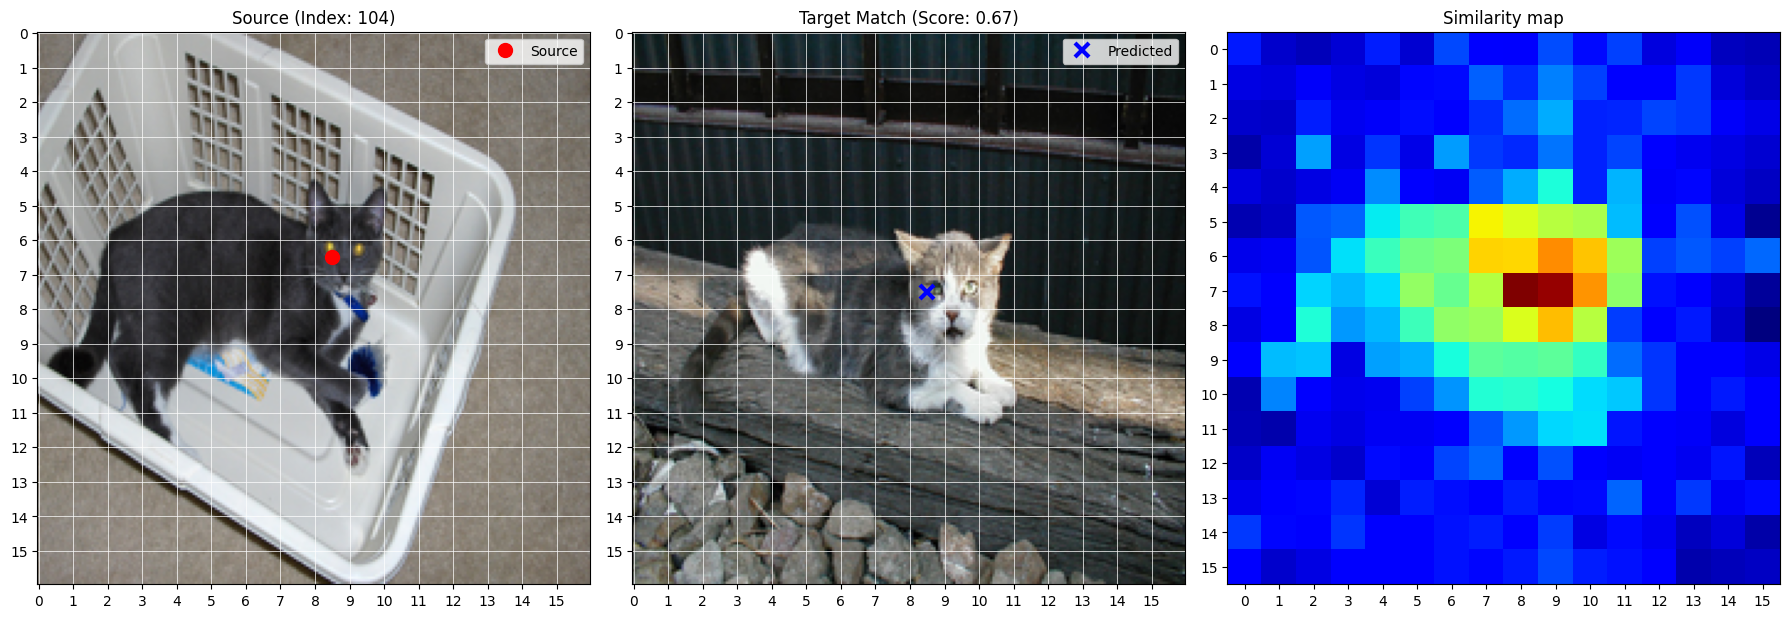

In [ ]:
## we already finish the part of getting featurses
## now lets start to calculate the similarity

import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# select one point what we want to know
source_point_index = 104 # left ear
source_feature = features_1[0, source_point_index, :].unsqueeze(0)

# colculate its similarity in the target image
target_features = features_2[0]
similarity = F.cosine_similarity(source_feature, target_features, dim=1) # use cosine to colculate

# find the match point
best_match_index = similarity.argmax().item()
print(f"Source point {source_point_index} matches best with Target point {best_match_index}")
print(f"Score: {similarity.max().item():.4f}")

# define the function about xy to draw points
def get_xy_from_index(index):
    grid_size = 16
    y, x = np.unravel_index(index, (grid_size, grid_size))
    scale_factor = 14
    return x * scale_factor + scale_factor // 2, y * scale_factor + scale_factor // 2

source_x, source_y = get_xy_from_index(source_point_index)
target_x, target_y = get_xy_from_index(best_match_index)

# draw the figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define a function to add grids
def setup_grid_axis(ax,title):
    ax.set_title(title)
    ticks = np.arange(0, 224, 14)   # every 14 pixels is a grid cell
    labels = np.arange(0, 16, 1)

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.grid(color='white', linestyle='-', linewidth=0.5)

# source
axes[0].imshow(image_source.resize((224, 224)))
axes[0].plot(source_x, source_y, 'ro', markersize=10, label='Source')
setup_grid_axis(axes[0], f"Source (Index: {source_point_index})")
axes[0].legend()

# target
axes[1].imshow(image_target.resize((224, 224)))
axes[1].plot(target_x, target_y, 'bx', markersize=10, markeredgewidth=3, label='Predicted')
setup_grid_axis(axes[1], f"Target Match (Score: {similarity.max().item():.2f})")
axes[1].legend()

# map
heatmap = similarity.reshape(16, 16).cpu().numpy()
axes[2].imshow(heatmap, cmap='jet')
axes[2].set_title("Similarity map")
axes[2].set_xticks(np.arange(0, 16, 1))
axes[2].set_yticks(np.arange(0, 16, 1))

plt.tight_layout()
plt.show()

Test cat

In [ ]:
## test cat in DINOv2
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration / 配置

BASE_DIR = 'spair_data/SPair-71k'
ANNOTATION_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')
CATEGORY = 'cat'

# Thresholds setting
THRESHOLDS = [0.05, 0.1, 0.2]

# Image parameters
IMG_SIZE = 448
PATCH_SIZE = 14

# Help Functions

def get_image_path(base_dir, rel_path, category):
    """
    Robust path joiner. Handles cases where category folder might be missing in JSON path.
    """
    # 1. Try direct join
    full_path = os.path.join(base_dir, rel_path)
    if os.path.exists(full_path):
        return full_path

    # 2. Try inserting category if not present (e.g. JPEGImages + cat + image.jpg)
    # 去除可能的前导斜杠
    rel_path_clean = rel_path.lstrip('/')
    alt_path = os.path.join(base_dir, category, rel_path_clean)
    if os.path.exists(alt_path):
        return alt_path

    return full_path

def load_image(path, new_size):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path does not exist: {path}")

    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor, (orig_w, orig_h)

def extract_features(model, img_tensor):
    with torch.no_grad():
        features_dict = model.forward_features(img_tensor)
        features = features_dict['x_norm_patchtokens']
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = features.reshape(1, h, w, -1)
    return features

def check_correctness(predicted_kps, gt_kps, bbox_size, thresholds):
    distances = np.linalg.norm(predicted_kps - gt_kps, axis=1)
    results = {}
    for alpha in thresholds:
        threshold_pixel = bbox_size * alpha
        results[alpha] = distances <= threshold_pixel
    return results

# Main Processing

def run_analysis():
    print(f"Loading DINOv2 Base model...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    model.eval()

    # Filter files strictly
    files = [f for f in os.listdir(ANNOTATION_DIR) if CATEGORY in f and f.endswith('.json')]
    print(f"Found {len(files)} annotation files for '{CATEGORY}'.")

    stats = {
        alpha: {'point_correct': 0, 'point_total': 0, 'image_scores': []}
        for alpha in THRESHOLDS
    }

    success_count = 0
    error_count = 0

    for i, filename in enumerate(tqdm(files)):
        try:
            with open(os.path.join(ANNOTATION_DIR, filename), 'r') as f:
                data = json.load(f)


            # 自动适配不同的键名
            if 'src_imname' in data:
                src_rel = data['src_imname']
                trg_rel = data['trg_imname']
            elif 'src_impath' in data:
                src_rel = data['src_impath']
                trg_rel = data['trg_impath']
            else:
                # If keys are missing, print available keys to help debug
                raise KeyError(f"Missing image path keys. Found keys: {list(data.keys())}")

            # Resolve full paths
            src_path = get_image_path(IMAGE_DIR, src_rel, CATEGORY)
            tgt_path = get_image_path(IMAGE_DIR, trg_rel, CATEGORY)

            # Load images
            src_img, src_size = load_image(src_path, IMG_SIZE)
            tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

            # Extract features
            src_feat = extract_features(model, src_img)
            tgt_feat = extract_features(model, tgt_img)

            # Normalize
            src_feat = F.normalize(src_feat, dim=-1)
            tgt_feat = F.normalize(tgt_feat, dim=-1)

            # Process Keypoints
            src_kps = np.array(data['src_kps'])
            tgt_kps = np.array(data['trg_kps'])
            tgt_bbox = data['trg_bndbox']

            bbox_w = tgt_bbox[2] - tgt_bbox[0]
            bbox_h = tgt_bbox[3] - tgt_bbox[1]
            bbox_size = max(bbox_w, bbox_h)

            predicted_points = []
            gt_points_filtered = []

            feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]

            for k in range(len(src_kps)):
                x, y = src_kps[k]

                # Map source to feature grid
                fx = int(x / src_size[0] * feat_w)
                fy = int(y / src_size[1] * feat_h)
                fx = min(max(fx, 0), feat_w - 1)
                fy = min(max(fy, 0), feat_h - 1)

                query_vec = src_feat[0, fy, fx, :].reshape(1, 1, -1)

                # Similarity map
                sim_map = torch.sum(tgt_feat * query_vec, dim=-1)

                # Argmax
                bs, h, w_feat = sim_map.shape
                idx = torch.argmax(sim_map.view(bs, -1))
                pred_y_idx = (idx // w_feat).item()
                pred_x_idx = (idx % w_feat).item()

                # Map back to target image
                pred_x = (pred_x_idx + 0.5) / w_feat * tgt_size[0]
                pred_y = (pred_y_idx + 0.5) / h * tgt_size[1]

                predicted_points.append([pred_x, pred_y])
                gt_points_filtered.append(tgt_kps[k])

            # Calculate Metrics
            if len(gt_points_filtered) > 0:
                results_dict = check_correctness(
                    np.array(predicted_points),
                    np.array(gt_points_filtered),
                    bbox_size,
                    THRESHOLDS
                )

                for alpha in THRESHOLDS:
                    correct_arr = results_dict[alpha]
                    stats[alpha]['point_correct'] += np.sum(correct_arr)
                    stats[alpha]['point_total'] += len(correct_arr)
                    stats[alpha]['image_scores'].append(np.mean(correct_arr))

            success_count += 1

        except Exception as e:
            error_count += 1
            if error_count <= 3: # Print first 3 errors only
                print(f"[ERROR] Failed on {filename}: {str(e)}")
            continue

    print(f"\nProcessing Complete. Success: {success_count}, Errors: {error_count}")

    # Generate Table
    table_data = []
    for alpha in THRESHOLDS:
        s = stats[alpha]
        pp_pck = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi_pck = (np.mean(s['image_scores']) * 100) if len(s['image_scores']) > 0 else 0

        table_data.append({
            "Threshold (alpha)": alpha,
            "PCK (Per Point) %": round(pp_pck, 2),
            "PCK (Per Image) %": round(pi_pck, 2)
        })

    df = pd.DataFrame(table_data)
    print("\n")
    print(f"Semantic Correspondence Results (Category: {CATEGORY})")
    print(f"Model: DINOv2 Base (Frozen)")
    print("-" * 50)
    print(df.to_markdown(index=False))
    print("-" * 50)

if __name__ == "__main__":
    run_analysis()

Using device: cuda
Loading DINOv2 Base model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Found 600 annotation files for 'cat'.


100%|██████████| 600/600 [00:40<00:00, 14.88it/s]


Processing Complete. Success: 600, Errors: 0


Semantic Correspondence Results (Category: cat)
Model: DINOv2 Base (Frozen)
--------------------------------------------------
|   Threshold (alpha) |   PCK (Per Point) % |   PCK (Per Image) % |
|--------------------:|--------------------:|--------------------:|
|                0.05 |               59.31 |               59.5  |
|                0.1  |               68.99 |               69.36 |
|                0.2  |               82.35 |               82.79 |
--------------------------------------------------


Test every categories and output results

In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = 'spair_data/SPair-71k'
ANNOTATION_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Thresholds setting
THRESHOLDS = [0.05, 0.1, 0.2]

CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]

IMG_SIZE = 448   # Model input size
PATCH_SIZE = 14  # DINOv2 patch size

# Helper Functions

def get_image_path(base_dir, rel_path, category):
    full_path = os.path.join(base_dir, rel_path)
    if os.path.exists(full_path): return full_path
    rel_path_clean = rel_path.lstrip('/').lstrip('\\')
    alt_path = os.path.join(base_dir, category, rel_path_clean)
    if os.path.exists(alt_path): return alt_path
    return full_path

def load_image(path, new_size):
    if not os.path.exists(path): raise FileNotFoundError(f"Missing: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size # Get original size!

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    # Return tensor AND original dimensions
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features(model, img_tensor):
    with torch.no_grad():
        features = model.forward_features(img_tensor)['x_norm_patchtokens']
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = features.reshape(1, h, w, -1)
    return features

# Main function

def run_corrected_evaluation():
    print(f"\nLoading DINOv2 Model...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    model.eval()

    # Global Stats container
    global_stats = {
        alpha: {'correct': 0, 'total': 0, 'img_scores': []}
        for alpha in THRESHOLDS
    }

    # Category Stats container
    category_stats = {}

    total_pairs_processed = 0

    print(f"Starting Corrected Evaluation (Fixing Coordinate Scaling)...")

    for category in CATEGORIES:
        category_stats[category] = {
            alpha: {'correct': 0, 'total': 0, 'img_scores': []}
            for alpha in THRESHOLDS
        }

        all_files = os.listdir(ANNOTATION_DIR)
        cat_files = [f for f in all_files if f.endswith('.json') and category in f]

        if not cat_files: continue

        print(f"Processing: {category} ({len(cat_files)} pairs)")

        for i, filename in enumerate(tqdm(cat_files, leave=False)):
            try:
                with open(os.path.join(ANNOTATION_DIR, filename), 'r') as f:
                    data = json.load(f)

                # Check keys
                src_key = 'src_imname' if 'src_imname' in data else 'src_impath' if 'src_impath' in data else None
                if src_key is None: continue

                # Load Images and ORIGINAL SIZES
                src_path = get_image_path(IMAGE_DIR, data[src_key], category)
                tgt_path = get_image_path(IMAGE_DIR, data['trg_imname'] if 'trg_imname' in data else data['trg_impath'], category)

                # We receive (orig_w, orig_h) here
                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                # Extract Features
                src_feat = F.normalize(extract_features(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features(model, tgt_img), dim=-1)

                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                tgt_bbox = data['trg_bndbox']
                bbox_size = max(tgt_bbox[2]-tgt_bbox[0], tgt_bbox[3]-tgt_bbox[1])

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]
                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]

                    # let map using original size
                    fx = int((x / src_size[0]) * feat_w)
                    fy = int((y / src_size[1]) * feat_h)

                    # Clip
                    fx = min(max(fx, 0), feat_w - 1)
                    fy = min(max(fy, 0), feat_h - 1)

                    # Query Similarity
                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    # Map back using ORIGINAL Target Size
                    pred_x_ratio = ((idx % feat_w) + 0.5) / feat_w
                    pred_y_ratio = ((idx // feat_w) + 0.5) / feat_h

                    pred_x = pred_x_ratio * tgt_size[0] # Scale by Original Width
                    pred_y = pred_y_ratio * tgt_size[1] # Scale by Original Height

                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                if gt_points_valid:
                    distances = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)

                    for alpha in THRESHOLDS:
                        is_correct = distances <= (bbox_size * alpha)

                        # renwe Global Stats
                        global_stats[alpha]['correct'] += np.sum(is_correct)
                        global_stats[alpha]['total'] += len(is_correct)
                        global_stats[alpha]['img_scores'].append(np.mean(is_correct))

                        # renew Category Stats
                        category_stats[category][alpha]['correct'] += np.sum(is_correct)
                        category_stats[category][alpha]['total'] += len(is_correct)
                        category_stats[category][alpha]['img_scores'].append(np.mean(is_correct))

                    total_pairs_processed += 1

            except Exception as e:
                continue


    # Output data table

    if total_pairs_processed == 0:
        print("No data processed.")
        return

    table_rows = []
    for alpha in THRESHOLDS:
        s = global_stats[alpha]
        per_point = (s['correct'] / s['total'] * 100) if s['total'] > 0 else 0
        per_image = (np.mean(s['img_scores']) * 100) if s['img_scores'] else 0

        table_rows.append({
            "Threshold": alpha,
            "PCK (Pt)%": round(per_point, 2),
            "PCK (Img)%": round(per_image, 2)
        })

    df = pd.DataFrame(table_rows)

    print("\n\n")
    print("=== Semantic Correspondence Results (Overall Average) ===")
    print("Model: DINOv2 Base (Frozen)")
    print("-" * 60)
    print(df.to_markdown(index=False, floatfmt=".2f"))
    print("-" * 60)
    print("\n\n")
    print("=== Per-Category Breakdown (PCK @ Per Point) ===")
    print("-" * 80)

    cat_rows = []
    for cat in CATEGORIES:
        if category_stats[cat][THRESHOLDS[0]]['total'] == 0:
            continue

        row = {"Category": cat}
        for alpha in THRESHOLDS:
            s = category_stats[cat][alpha]
            pp = (s['correct'] / s['total'] * 100) if s['total'] > 0 else 0
            row[f"PCK@{alpha}"] = round(pp, 2)
        cat_rows.append(row)

    df_cat = pd.DataFrame(cat_rows)
    print(df_cat.to_markdown(index=False, floatfmt=".2f"))
    print("-" * 80)

if __name__ == "__main__":
    run_corrected_evaluation()


Loading DINOv2 Model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Starting Corrected Evaluation (Fixing Coordinate Scaling)...
Processing: aeroplane (690 pairs)


Processing: bicycle (650 pairs)


Processing: bird (702 pairs)


Processing: boat (702 pairs)


Processing: bottle (870 pairs)


Processing: bus (644 pairs)


Processing: car (564 pairs)


Processing: cat (600 pairs)


Processing: chair (646 pairs)


Processing: cow (640 pairs)


Processing: dog (600 pairs)


Processing: horse (600 pairs)


Processing: motorbike (702 pairs)


Processing: person (650 pairs)


Processing: pottedplant (862 pairs)


Processing: sheep (664 pairs)


Processing: train (756 pairs)


Processing: tvmonitor (692 pairs)





=== Semantic Correspondence Results (Overall Average) ===
Model: DINOv2 Base (Frozen)
------------------------------------------------------------
|   Threshold |   PCK (Pt)% |   PCK (Img)% |
|------------:|------------:|-------------:|
|        0.05 |       36.04 |        33.64 |
|        0.10 |       53.42 |        50.75 |
|        0.20 |       69.93 |        67.15 |
------------------------------------------------------------



=== Per-Category Breakdown (PCK @ Per Point) ===
--------------------------------------------------------------------------------
| Category    |   PCK@0.05 |   PCK@0.1 |   PCK@0.2 |
|:------------|-----------:|----------:|----------:|
| aeroplane   |      55.34 |     70.05 |     82.22 |
| bicycle     |      38.67 |     60.14 |     74.99 |
| bird        |      58.33 |     83.05 |     94.30 |
| boat        |      19.70 |     34.05 |     50.95 |
| bottle      |      27.17 |     44.69 |     64.43 |
| bus         |      36.27 |     49.11 |     61.48 |
| car  

# 1 Test DINOv3

In [ ]:
## Download DINOv3 from hugging face
# Environment Setup
# DINOv3 requires the latest transformers and accelerate libraries
# Add your hugging face token to use DINOv3 !!!!!!!
!pip install -q -U transformers accelerate timm einops

print("Authenticating with Hugging Face")
from huggingface_hub import login
login()

print("Setup complete")

Authenticating with Hugging Face...


Setup complete


In [ ]:
# Main function of DINOv3
# Model we used is DINOv3-vitl16-pretrain-lvd1689m
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path Settings
BASE_DIR = 'spair_data/SPair-71k'
ANNOTATION_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Categories to evaluate
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]

# Thresholds setting
THRESHOLDS = [0.05, 0.1, 0.2]



# DINOv3 Large from hugging Face
MODEL_ID = "facebook/dinov3-vitl16-pretrain-lvd1689m"

# Image size must be multiple of patch size (16)
IMG_SIZE = 448
PATCH_SIZE = 16

# Helper Functions

def get_image_path(base_dir, rel_path, category):
    full_path = os.path.join(base_dir, rel_path)
    if os.path.exists(full_path): return full_path

    # Try adding category folder / 尝试添加类别文件夹
    rel_path_clean = rel_path.lstrip('/').lstrip('\\')
    alt_path = os.path.join(base_dir, category, rel_path_clean)
    if os.path.exists(alt_path): return alt_path

    return full_path

def load_image(path, new_size):
    if not os.path.exists(path): raise FileNotFoundError(f"Missing file: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size # Important: Keep original W/H / 重要：保留原始宽高

    # Standard normalization for DINO models
    # DINO 模型的标准归一化处理
    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features_dinov3(model, img_tensor):

    with torch.no_grad():
        # Forward pass / 前向传播
        outputs = model(pixel_values=img_tensor)
        last_hidden_state = outputs.last_hidden_state

        # DINOv3 has 1 CLS token + 4 Register tokens at the beginning.
        # We must skip the first 5 tokens to get the actual image patches.
        patch_tokens = last_hidden_state[:, 5:, :]

        # Reshape to grid (H, W) / 重塑为网格形状
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = patch_tokens.reshape(1, h, w, -1)

    return features

# Main execution logic


def run_dinov3_evaluation():
    print(f"\n Downloadin Model: {MODEL_ID}...")

    try:
        # Load model using Transformers library
        model = AutoModel.from_pretrained(MODEL_ID).to(device)
        model.eval()
        print("Model loaded successfully")
    except Exception as e:
        print("\n Model load failed. Did you run Part 1 and enter the token?")
        print(f"Error details :{e}")
        return

    # Initialize stats containers
    global_stats = {
        alpha: {'correct': 0, 'total': 0, 'img_scores': []}
        for alpha in THRESHOLDS
    }

    total_pairs = 0
    print(f"Starting DINOv3 Evaluation...")

    # Loop categories
    for category in CATEGORIES:
        all_files = os.listdir(ANNOTATION_DIR)
        cat_files = [f for f in all_files if f.endswith('.json') and category in f]

        if not cat_files: continue

        print(f"Processing Category: {category} ({len(cat_files)} pairs)")

        for i, filename in enumerate(tqdm(cat_files, leave=False)):
            try:
                # Load JSON annotation
                with open(os.path.join(ANNOTATION_DIR, filename), 'r') as f:
                    data = json.load(f)

                # Dynamic key check
                src_key = 'src_imname' if 'src_imname' in data else 'src_impath' if 'src_impath' in data else None
                if src_key is None: continue

                # Get Paths
                src_path = get_image_path(IMAGE_DIR, data[src_key], category)
                tgt_path = get_image_path(IMAGE_DIR, data['trg_imname'] if 'trg_imname' in data else data['trg_impath'], category)

                # Load Images (src_size is original size)
                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                # Extract Features
                src_feat = F.normalize(extract_features_dinov3(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features_dinov3(model, tgt_img), dim=-1)

                # Keypoints Data
                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                tgt_bbox = data['trg_bndbox']
                bbox_size = max(tgt_bbox[2]-tgt_bbox[0], tgt_bbox[3]-tgt_bbox[1])

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]
                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]

                    # Map Original -> Feature Grid
                    fx = min(max(int((x / src_size[0]) * feat_w), 0), feat_w - 1)
                    fy = min(max(int((y / src_size[1]) * feat_h), 0), feat_h - 1)

                    # Cosine Similarity
                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    # Map Feature Grid
                    pred_x = ((idx % feat_w) + 0.5) / feat_w * tgt_size[0]
                    pred_y = ((idx // feat_w) + 0.5) / feat_h * tgt_size[1]

                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                # Check accuracy against all thresholds
                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        global_stats[alpha]['correct'] += np.sum(is_correct)
                        global_stats[alpha]['total'] += len(is_correct)
                        global_stats[alpha]['img_scores'].append(np.mean(is_correct))
                    total_pairs += 1

            except Exception:
                continue

    # Result output
    if total_pairs == 0:
        print("No data processed.")
    else:
        table_rows = []
        for alpha in THRESHOLDS:
            s = global_stats[alpha]
            pp = (s['correct'] / s['total'] * 100) if s['total'] > 0 else 0
            pi = (np.mean(s['img_scores']) * 100) if s['img_scores'] else 0
            table_rows.append({
                "Threshold (alpha)": alpha,
                "PCK (Per Point) %": round(pp, 2),
                "PCK (Per Image) %": round(pi, 2)
            })

        print("\n" + "="*60)
        print("FINAL RESULTS: DINOv3 (ViT-Large-16)")
        print("============================================================")
        print(pd.DataFrame(table_rows).to_markdown(index=False))
        print("============================================================")

if __name__ == "__main__":
    run_dinov3_evaluation()

Hardware Status (硬件状态): NVIDIA A100-SXM4-80GB

   (This uses your Token from Part 1 / 将使用第一步输入的 Token)
Model loaded successfully! / 模型加载成功！
Starting DINOv3 Evaluation...
Processing Category: aeroplane (690 pairs)


Processing Category: bicycle (650 pairs)


Processing Category: bird (702 pairs)


Processing Category: boat (702 pairs)


Processing Category: bottle (870 pairs)


Processing Category: bus (644 pairs)


Processing Category: car (564 pairs)


Processing Category: cat (600 pairs)


Processing Category: chair (646 pairs)


Processing Category: cow (640 pairs)


Processing Category: dog (600 pairs)


Processing Category: horse (600 pairs)


Processing Category: motorbike (702 pairs)


Processing Category: person (650 pairs)


Processing Category: pottedplant (862 pairs)


Processing Category: sheep (664 pairs)


Processing Category: train (756 pairs)


Processing Category: tvmonitor (692 pairs)



FINAL RESULTS: DINOv3 (ViT-Large-16)
|   Threshold (alpha) |   PCK (Per Point) % |   PCK (Per Image) % |
|--------------------:|--------------------:|--------------------:|
|                0.05 |               35.78 |               32.8  |
|                0.1  |               54.86 |               51.12 |
|                0.2  |               71.32 |               67.44 |


# 1 Test SAM


In [ ]:

# Environment setup
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

# Download the official ViT-Large checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

print("Setup complete")

  Preparing metadata (setup.py) ... done
Setup complete


In [ ]:
## Test SAM-Large
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from segment_anything import sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path settings
BASE_DIR = 'spair_data/SPair-71k'
ANNOTATION_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Categories
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]

# Thresholds
THRESHOLDS = [0.05, 0.1, 0.2]

# Model configuration
# size of image is 1024
IMG_SIZE = 1024
PATCH_SIZE = 16


# Helper Functions

def get_image_path(base_dir, rel_path, category):

    full_path = os.path.join(base_dir, rel_path)
    if os.path.exists(full_path): return full_path
    rel_path_clean = rel_path.lstrip('/').lstrip('\\')
    alt_path = os.path.join(base_dir, category, rel_path_clean)
    if os.path.exists(alt_path): return alt_path
    return full_path

def load_image(path, new_size):

    if not os.path.exists(path): raise FileNotFoundError(f"Missing file: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features_sam(model, img_tensor):

    with torch.no_grad():
        # SAM's image encoder outputs (Batch, 256, 64, 64)
        features = model.image_encoder(img_tensor)

        # Permute to (Batch, 64, 64, 256) for processing
        features = features.permute(0, 2, 3, 1)

    return features

# Main Logic

def run_sam_large_evaluation():
    print(f"\n Loading SAM (ViT-Large)...")

    # Load SAM Large using the checkpoint downloaded before
    try:
        sam = sam_model_registry["vit_l"](checkpoint="sam_vit_l_0b3195.pth")
        sam.to(device)
        sam.eval() # Freeze model
        print("SAM-Large loaded successfully")
    except Exception as e:
        print(f"Model load failed. Did you run Part 1? Error: {e}")
        return

    global_stats = {
        alpha: {'correct': 0, 'total': 0, 'img_scores': []}
        for alpha in THRESHOLDS
    }

    total_pairs = 0
    print(f"Starting SAM Evaluation")

    for category in CATEGORIES:
        all_files = os.listdir(ANNOTATION_DIR)
        cat_files = [f for f in all_files if f.endswith('.json') and category in f]

        if not cat_files: continue

        print(f"Processing Category: {category} ({len(cat_files)} pairs)")

        for i, filename in enumerate(tqdm(cat_files, leave=False)):
            try:
                with open(os.path.join(ANNOTATION_DIR, filename), 'r') as f:
                    data = json.load(f)

                # Check keys
                src_key = 'src_imname' if 'src_imname' in data else 'src_impath' if 'src_impath' in data else None
                if src_key is None: continue

                # Paths
                src_path = get_image_path(IMAGE_DIR, data[src_key], category)
                tgt_path = get_image_path(IMAGE_DIR, data['trg_imname'] if 'trg_imname' in data else data['trg_impath'], category)

                # Load Images (1024x1024)
                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                # Extract Features
                src_feat = F.normalize(extract_features_sam(sam, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features_sam(sam, tgt_img), dim=-1)

                # Metadata
                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                tgt_bbox = data['trg_bndbox']
                bbox_size = max(tgt_bbox[2]-tgt_bbox[0], tgt_bbox[3]-tgt_bbox[1])

                # Feature Dimensions
                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]

                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]

                    # Coordinate Mapping
                    fx = min(max(int((x / src_size[0]) * feat_w), 0), feat_w - 1)
                    fy = min(max(int((y / src_size[1]) * feat_h), 0), feat_h - 1)

                    # Similarity
                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    # Reverse Mapping
                    pred_x_ratio = ((idx % feat_w) + 0.5) / feat_w
                    pred_y_ratio = ((idx // feat_w) + 0.5) / feat_h

                    pred_x = pred_x_ratio * tgt_size[0]
                    pred_y = pred_y_ratio * tgt_size[1]

                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                # Stats
                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        global_stats[alpha]['correct'] += np.sum(is_correct)
                        global_stats[alpha]['total'] += len(is_correct)
                        global_stats[alpha]['img_scores'].append(np.mean(is_correct))
                    total_pairs += 1

            except Exception:
                continue

    # Result output
    if total_pairs == 0:
        print("No data processed. / 无数据。")
    else:
        table_rows = []
        for alpha in THRESHOLDS:
            s = global_stats[alpha]
            pp = (s['correct'] / s['total'] * 100) if s['total'] > 0 else 0
            pi = (np.mean(s['img_scores']) * 100) if s['img_scores'] else 0
            table_rows.append({
                "Threshold (alpha)": alpha,
                "PCK (Per Point) %": round(pp, 2),
                "PCK (Per Image) %": round(pi, 2)
            })

        print("FINAL RESULTS: SAM ViT-Large")
        print(pd.DataFrame(table_rows).to_markdown(index=False))

if __name__ == "__main__":
    run_sam_large_evaluation()

Hardware Status (硬件状态): NVIDIA A100-SXM4-80GB

 Loading SAM (ViT-Large)...
SAM (Large) loaded successfully! / 模型加载成功！
Starting SAM Evaluation (Model: ViT-Large)...
Processing Category: aeroplane (690 pairs)


Processing Category: bicycle (650 pairs)


Processing Category: bird (702 pairs)


Processing Category: boat (702 pairs)


Processing Category: bottle (870 pairs)


Processing Category: bus (644 pairs)


Processing Category: car (564 pairs)


Processing Category: cat (600 pairs)


Processing Category: chair (646 pairs)


Processing Category: cow (640 pairs)


Processing Category: dog (600 pairs)


Processing Category: horse (600 pairs)


Processing Category: motorbike (702 pairs)


Processing Category: person (650 pairs)


Processing Category: pottedplant (862 pairs)


Processing Category: sheep (664 pairs)


Processing Category: train (756 pairs)


Processing Category: tvmonitor (692 pairs)



FINAL RESULTS: Segment Anything (SAM ViT-Large)
|   Threshold (alpha) |   PCK (Per Point) % |   PCK (Per Image) % |
|--------------------:|--------------------:|--------------------:|
|                0.05 |               15.67 |               13.21 |
|                0.1  |               24.58 |               21.27 |
|                0.2  |               38.68 |               34.3  |


# 1 Results for three model

In [ ]:
import pandas as pd


# DINOv2 results
dinov2_per_point = [36.04, 53.42, 69.93]
dinov2_per_image = [33.64, 50.75, 67.15]

# DINOv3 results
dinov3_per_point = [35.78, 54.86, 71.32]
dinov3_per_image = [32.80, 51.12, 67.44]

# SAM results
sam_per_point    = [15.67, 24.58, 38.68]
sam_per_image    = [13.21, 21.27, 34.30]

thresholds = [0.05, 0.1, 0.2]


data = {
    "Threshold": thresholds,
    # DINOv2
    "DINOv2 (Point)%": dinov2_per_point,
    "DINOv2 (Image)%": dinov2_per_image,
    # DINOv3
    "DINOv3 (Point)%": dinov3_per_point,
    "DINOv3 (Image)%": dinov3_per_image,
    # SAM
    "SAM (Point)%": sam_per_point,
    "SAM (Image)%": sam_per_image
}

df_final = pd.DataFrame(data)

# print data table
print("\n" + "="*100)
print("FINAL COMPREHENSIVE RESULTS")
print("Metric: PCK@T (Percentage of Correct Keypoints)")
print("="*100)
print(df_final.to_markdown(index=False, floatfmt=".2f"))
print("="*100)

print("\n 转置：")
df_transposed = df_final.set_index('Threshold').T
print(df_transposed.to_markdown(floatfmt=".2f"))


FINAL COMPREHENSIVE RESULTS
Metric: PCK@T (Percentage of Correct Keypoints)
|   Threshold |   DINOv2 (Point)% |   DINOv2 (Image)% |   DINOv3 (Point)% |   DINOv3 (Image)% |   SAM (Point)% |   SAM (Image)% |
|------------:|------------------:|------------------:|------------------:|------------------:|---------------:|---------------:|
|        0.05 |             36.04 |             33.64 |             35.78 |             32.80 |          15.67 |          13.21 |
|        0.10 |             53.42 |             50.75 |             54.86 |             51.12 |          24.58 |          21.27 |
|        0.20 |             69.93 |             67.15 |             71.32 |             67.44 |          38.68 |          34.30 |

 转置：
|                 |   0.05 |   0.1 |   0.2 |
|:----------------|-------:|------:|------:|
| DINOv2 (Point)% |  36.04 | 53.42 | 69.93 |
| DINOv2 (Image)% |  33.64 | 50.75 | 67.15 |
| DINOv3 (Point)% |  35.78 | 54.86 | 71.32 |
| DINOv3 (Image)% |  32.80 | 51.12 | 67.44

# 2 DINOv2- 1 layer

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler


# Config & Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# PATHS BASED ON YOUR INFO
BASE_DIR = '/content/spair_data/SPair-71k'
TRAIN_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'trn')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')
SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Training models'

# Hyperparameters (Speed Optimized)
IMG_SIZE = 448
PATCH_SIZE = 14
# Increase batch size for speed (AMP allows this)
BATCH_SIZE = 16     # 增大批次以加速
LEARNING_RATE = 1e-4
EPOCHS = 3
NUM_WORKERS = 2     # 开启多线程加载数据

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Model save directory: {SAVE_DIR}")


# Dataset Class
class SPairDataset(Dataset):
    def __init__(self, anno_dir, img_dir, img_size):
        self.img_dir = img_dir
        # Only load valid json files
        self.files = [os.path.join(anno_dir, f) for f in os.listdir(anno_dir) if f.endswith('.json')]
        self.img_size = img_size

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        print(f"Loaded {len(self.files)} training pairs.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Parse JSON
        filepath = self.files[idx]
        with open(filepath, 'r') as f:
            data = json.load(f)

        # Extract Category correctly

        filename = os.path.basename(filepath)
        if ':' in filename:
            category = filename.split(':')[-1].replace('.json', '')
        else:
            # Fallback for filenames without colon
            category = filename.split('_')[-1].replace('.json', '')

        # Resolve Paths
        src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
        trg_key = 'trg_imname' if 'trg_imname' in data else 'trg_impath'

        src_path = self._get_path(data[src_key], category)
        tgt_path = self._get_path(data[trg_key], category)

        # Load Data
        src_img, src_size = self._load_img(src_path)
        tgt_img, tgt_size = self._load_img(tgt_path)

        src_kps = torch.tensor(data['src_kps'])
        tgt_kps = torch.tensor(data['trg_kps'])

        return src_img, tgt_img, src_kps, tgt_kps, torch.tensor(src_size), torch.tensor(tgt_size)

    def _get_path(self, filename, category):
        """
        Constructs path: JPEGImages / category / filename
        """
        # Remove any leading slashes
        clean_name = filename.lstrip('/').lstrip('\\')

        # If the json already includes category (rare), check direct
        full_path_direct = os.path.join(self.img_dir, clean_name)
        if os.path.exists(full_path_direct):
            return full_path_direct

        # Otherwise, construct with category folder
        full_path_cat = os.path.join(self.img_dir, category, clean_name)
        return full_path_cat

    def _load_img(self, path):
        if not os.path.exists(path):
            # Detailed error to help debug if it happens again
            raise FileNotFoundError(f"Missing: {path}")
        img = Image.open(path).convert('RGB')
        w, h = img.size
        return self.transform(img), np.array([w, h])


# Custom Collate & Soft-Argmax

def custom_collate(batch):
    # Filters out None values if any error occurred during loading
    batch = [b for b in batch if b is not None]
    if len(batch) == 0: return None

    src_imgs = torch.stack([item[0] for item in batch])
    tgt_imgs = torch.stack([item[1] for item in batch])
    src_kps = [item[2] for item in batch] # List
    tgt_kps = [item[3] for item in batch] # List
    src_sizes = torch.stack([item[4] for item in batch])
    tgt_sizes = torch.stack([item[5] for item in batch])

    return src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes

def soft_argmax(heatmap, beta=100.0):
    b, h, w = heatmap.shape
    heatmap = heatmap.view(b, -1)
    prob = F.softmax(beta * heatmap, dim=-1)

    xx, yy = torch.meshgrid(torch.arange(w, device=heatmap.device),
                            torch.arange(h, device=heatmap.device), indexing='xy')
    xx = xx.flatten().float()
    yy = yy.flatten().float()

    expected_x = torch.sum(prob * xx, dim=-1)
    expected_y = torch.sum(prob * yy, dim=-1)

    return torch.stack([expected_x, expected_y], dim=-1)

# Training Function (Accelerated)
def train_one_epoch(model, dataloader, optimizer, scaler, epoch_idx):
    model.train()
    total_loss = 0
    valid_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{EPOCHS}")

    for batch in pbar:
        if batch is None: continue

        try:
            src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes = batch
            src_imgs, tgt_imgs = src_imgs.to(device), tgt_imgs.to(device)
            # KPs stay as list, move to device in loop

            optimizer.zero_grad()

            # Mixed Precision Context to Speedup
            #
            with autocast():
                # 1. Forward
                src_dict = model.forward_features(src_imgs)
                tgt_dict = model.forward_features(tgt_imgs)
                src_feat = src_dict['x_norm_patchtokens']
                tgt_feat = tgt_dict['x_norm_patchtokens']

                h_grid = w_grid = int(IMG_SIZE / PATCH_SIZE)
                src_feat = src_feat.reshape(-1, h_grid, w_grid, src_feat.shape[-1])
                tgt_feat = tgt_feat.reshape(-1, h_grid, w_grid, tgt_feat.shape[-1])

                src_feat = F.normalize(src_feat, dim=-1)
                tgt_feat = F.normalize(tgt_feat, dim=-1)

                batch_loss = torch.tensor(0.0, device=device)
                points_count = 0

                # 2. Loss Calculation
                for b in range(src_imgs.shape[0]):
                    s_kps = src_kps[b].to(device)
                    t_kps = tgt_kps[b].to(device)
                    s_size = src_sizes[b]
                    t_size = tgt_sizes[b]

                    if len(s_kps) == 0: continue

                    # Map Source to Grid
                    # Using vectorized operations where possible would be faster,
                    # but loop is clearer for variable keypoints.
                    grid_sx = (s_kps[:, 0] / s_size[0]) * w_grid
                    grid_sy = (s_kps[:, 1] / s_size[1]) * h_grid

                    # Clamp
                    grid_sx = grid_sx.round().long().clamp(0, w_grid - 1)
                    grid_sy = grid_sy.round().long().clamp(0, h_grid - 1)

                    # Batch index for gathering features
                    queries = src_feat[b, grid_sy, grid_sx, :] # (N_kps, Dim)

                    # Similarity: (H, W, Dim) x (N_kps, Dim) -> (N_kps, H, W)
                    tgt_feat_flat = tgt_feat[b].view(-1, tgt_feat.shape[-1]) # (HW, Dim)
                    sim_maps = torch.matmul(queries, tgt_feat_flat.t()) # (N_kps, HW)
                    sim_maps = sim_maps.view(-1, h_grid, w_grid) # (N_kps, H, W)

                    # Soft Argmax on batch of keypoints
                    pred_xy = soft_argmax(sim_maps) # (N_kps, 2)

                    # Ground Truth Grid Coords
                    gt_gx = (t_kps[:, 0] / t_size[0]) * w_grid
                    gt_gy = (t_kps[:, 1] / t_size[1]) * h_grid
                    gt_xy = torch.stack([gt_gx, gt_gy], dim=-1)

                    batch_loss += F.mse_loss(pred_xy, gt_xy)
                    points_count += 1

            # Scaled Backward Pass
            if points_count > 0:
                final_loss = batch_loss / points_count
                scaler.scale(final_loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_loss += final_loss.item()
                valid_batches += 1
                pbar.set_postfix({'loss': f"{final_loss.item():.4f}"})

        except Exception as e:
            # print(f"Error in batch: {e}")
            continue

    return total_loss / valid_batches if valid_batches > 0 else 0


# Main Execution
def run_finetuning():
    print("Loading DINOv2 Base model...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)

    # Freeze/Unfreeze
    for param in model.parameters():
        param.requires_grad = False

    print("Unfreezing the LAST layer (model.blocks[-1])...")
    for param in model.blocks[-1].parameters():
        param.requires_grad = True
    for param in model.norm.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {trainable_params / 1e6:.2f} Million")

    # Dataset & Loader (with workers)
    dataset = SPairDataset(TRAIN_ANNO_DIR, IMAGE_DIR, IMG_SIZE)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        collate_fn=custom_collate,
        num_workers=NUM_WORKERS, # Faster loading
        pin_memory=True          # Faster GPU transfer
    )

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scaler = GradScaler() # For mixed precision

    print(f"Starting Fast Fine-tuning (Last Layer) for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):
        avg_loss = train_one_epoch(model, dataloader, optimizer, scaler, epoch)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    save_path = os.path.join(SAVE_DIR, 'dinov2_base_1L.pth')
    torch.save(model.state_dict(), save_path)
    print(f"Fine-tuning complete. Model saved to: {save_path}")

if __name__ == "__main__":
    run_finetuning()

Using Hardware: NVIDIA A100-SXM4-80GB
Loading DINOv2 Base model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipython-input-274762658.py:274: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # For mixed precision


Unfreezing the LAST layer (model.blocks[-1])...
Trainable Parameters: 7.09 Million
Loaded 53340 training pairs.
Starting Fast Fine-tuning (Last Layer) for 3 epochs...


Epoch 1/3:   0%|          | 0/3333 [00:00<?, ?it/s]/tmp/ipython-input-274762658.py:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3: 100%|██████████| 3333/3333 [07:48<00:00,  7.11it/s, loss=3.0692]


Epoch 1 Average Loss: 5.6380


Epoch 2/3: 100%|██████████| 3333/3333 [08:42<00:00,  6.38it/s, loss=1.0042]


Epoch 2 Average Loss: 1.9873


Epoch 3/3: 100%|██████████| 3333/3333 [08:48<00:00,  6.30it/s, loss=4.3412]


Epoch 3 Average Loss: 1.5250
Fine-tuning complete. Model saved to: /content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_finetuned_last1.pth


Test DNINOv2 only fine-tunning the last layer

In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
BASE_DIR = '/content/spair_data/SPair-71k'
TEST_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Path to your FINE-TUNED model
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_1L.pth'

# Where to save the result CSV
RESULT_SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Results'
CSV_FILENAME = 'comparison_v2.csv'
if not os.path.exists(RESULT_SAVE_DIR):
    os.makedirs(RESULT_SAVE_DIR)
RESULT_CSV_PATH = os.path.join(RESULT_SAVE_DIR, CSV_FILENAME)

# Evaluation Settings
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]
THRESHOLDS = [0.05, 0.1, 0.2]
IMG_SIZE = 448
PATCH_SIZE = 14


# Helper Functions
print("[INFO] Indexing images... (Please wait)")
IMAGE_MAP = {}
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            IMAGE_MAP[file] = os.path.join(root, file)
print(f"[INFO] Indexed {len(IMAGE_MAP)} images.")

def get_full_path(rel_path):
    filename = os.path.basename(rel_path)
    if filename in IMAGE_MAP:
        return IMAGE_MAP[filename]
    return os.path.join(IMAGE_DIR, rel_path)

def load_image(path, new_size):
    if not os.path.exists(path): raise FileNotFoundError(f"Missing: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features(model, img_tensor):
    with torch.no_grad():
        features = model.forward_features(img_tensor)['x_norm_patchtokens']
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = features.reshape(1, h, w, -1)
    return features


# Evaluation Process
def run_eval_and_save():
    # Load Model
    print(f"[INFO] Loading Model weights from: {MODEL_PATH}")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    if os.path.exists(MODEL_PATH):
        state_dict = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print("[WARNING] Model not found! Running with baseline weights.")
    model.eval()

    # Stats
    stats = {alpha: {'point_correct': 0, 'point_total': 0, 'image_scores': []} for alpha in THRESHOLDS}

    print(f"[INFO] Starting Evaluation...")
    for category in CATEGORIES:
        files = [f for f in os.listdir(TEST_ANNO_DIR) if f.endswith('.json') and category in f]
        if not files: continue

        for i, filename in enumerate(tqdm(files, leave=False, desc=f"Eval {category}")):
            try:
                with open(os.path.join(TEST_ANNO_DIR, filename), 'r') as f: data = json.load(f)
                src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
                if src_key is None: continue

                src_path = get_full_path(data[src_key])
                tgt_path = get_full_path(data['trg_imname'] if 'trg_imname' in data else data['trg_impath'])

                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                src_feat = F.normalize(extract_features(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features(model, tgt_img), dim=-1)

                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                bbox_size = max(data['trg_bndbox'][2]-data['trg_bndbox'][0], data['trg_bndbox'][3]-data['trg_bndbox'][1])

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]
                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]
                    fx = int((x / src_size[0]) * feat_w)
                    fy = int((y / src_size[1]) * feat_h)
                    fx = min(max(fx, 0), feat_w - 1)
                    fy = min(max(fy, 0), feat_h - 1)

                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    pred_x = ((idx % feat_w) + 0.5) / feat_w * tgt_size[0]
                    pred_y = ((idx // feat_w) + 0.5) / feat_h * tgt_size[1]
                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        stats[alpha]['point_correct'] += np.sum(is_correct)
                        stats[alpha]['point_total'] += len(is_correct)
                        stats[alpha]['image_scores'].append(np.mean(is_correct))
            except Exception:
                continue

    # Calculate Final Metrics
    results = []
    for alpha in THRESHOLDS:
        s = stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['image_scores']) * 100) if s['image_scores'] else 0
        results.append({"Threshold": alpha, "FT_Point": pp, "FT_Image": pi})

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(RESULT_CSV_PATH, index=False)
    print("\n" + "="*60)
    print(f"[SUCCESS] Results saved to Drive: {RESULT_CSV_PATH}")
    print("="*60)
    print(df.to_markdown(index=False, floatfmt=".2f"))

if __name__ == "__main__":
    run_eval_and_save()

[INFO] Indexing images... (Please wait)
[INFO] Indexed 1776 images.
[INFO] Loading Model weights from: /content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_finetuned_last1.pth
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 232MB/s]


[INFO] Starting Evaluation...



[SUCCESS] Results saved to Drive: /content/drive/MyDrive/Project_Semantic/Results/comparison_v2.csv
|   Threshold |   FT_Point |   FT_Image |
|------------:|-----------:|-----------:|
|        0.05 |      51.00 |      47.91 |
|        0.10 |      73.74 |      70.91 |
|        0.20 |      88.33 |      86.41 |


In [ ]:
## draw the data table, compare original model and modified model
import pandas as pd
import os
from google.colab import drive

# Mount Drive (if needed)

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path to the saved CSV
RESULT_CSV_PATH = '/content/drive/MyDrive/Project_Semantic/Results/finetuned_test_results.csv'

# Baseline Data (Hardcoded from your screenshot)
# 基线数据 (硬编码)
baseline_point = [36.04, 53.42, 69.93]
baseline_image = [33.64, 50.75, 67.15]

# Generate Report
def generate_report():
    if not os.path.exists(RESULT_CSV_PATH):
        print(f"[ERROR] Result file not found: {RESULT_CSV_PATH}")
        print("Please run Part 1 first.")
        return

    # Load fine-tuned results
    df_ft = pd.read_csv(RESULT_CSV_PATH)

    # Create comparison DataFrames
    # Per Point Comparison
    df_point = pd.DataFrame({
        "Threshold": df_ft["Threshold"],
        "Baseline (Frozen)%": baseline_point,
        "Fine-tuned (Last 1)%": df_ft["FT_Point"]
    })
    df_point["Improvement"] = df_point["Fine-tuned (Last 1)%"] - df_point["Baseline (Frozen)%"]
    df_point["Improvement"] = df_point["Improvement"].apply(lambda x: f"+{x:.2f}" if x>0 else f"{x:.2f}")

    # Per Image Comparison
    df_image = pd.DataFrame({
        "Threshold": df_ft["Threshold"],
        "Baseline (Frozen)%": baseline_image,
        "Fine-tuned (Last 1)%": df_ft["FT_Image"]
    })
    df_image["Improvement"] = df_image["Fine-tuned (Last 1)%"] - df_image["Baseline (Frozen)%"]
    df_image["Improvement"] = df_image["Improvement"].apply(lambda x: f"+{x:.2f}" if x>0 else f"{x:.2f}")

    # Print
    print("\n" + "="*80)
    print("FINAL COMPARISON 1: PER POINT ACCURACY")
    print("Model: DINOv2 Base | Task: Light Fine-tuning")
    print("="*80)
    print(df_point.to_markdown(index=False, floatfmt=".2f"))

    print("\n\n" + "="*80)
    print("FINAL COMPARISON 2: PER IMAGE ACCURACY")
    print("Model: DINOv2 Base | Task: Light Fine-tuning")
    print("="*80)
    print(df_image.to_markdown(index=False, floatfmt=".2f"))

if __name__ == "__main__":
    generate_report()

[ERROR] Result file not found: /content/drive/MyDrive/Project_Semantic/Results/finetuned_test_results.csv
Please run Part 1 first.


# 2 DINOv2- 2 layers

# 2 DINOv2- 3 layers

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler


# Config Parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Paths
BASE_DIR = '/content/spair_data/SPair-71k'
TRAIN_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'trn')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Save path for the 3-layer model
SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Training models'

# Hyperparameters
IMG_SIZE = 448
PATCH_SIZE = 14
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 3
NUM_WORKERS = 2

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Dataset Class (Robust Indexing)
class SPairDataset(Dataset):
    def __init__(self, anno_dir, img_dir, img_size):
        self.img_dir = img_dir
        self.files = [os.path.join(anno_dir, f) for f in os.listdir(anno_dir) if f.endswith('.json')]
        self.img_size = img_size

        print("Indexing images... (Please wait)")
        self.image_map = {}
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_map[file] = os.path.join(root, file)
        print(f"Indexed {len(self.image_map)} images.")

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        print(f"Loaded {len(self.files)} training pairs.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data = json.load(f)

        src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
        trg_key = 'trg_imname' if 'trg_imname' in data else 'trg_impath'

        src_path = self._lookup_path(data[src_key])
        tgt_path = self._lookup_path(data[trg_key])

        src_img, src_size = self._load_img(src_path)
        tgt_img, tgt_size = self._load_img(tgt_path)

        src_kps = torch.tensor(data['src_kps'])
        tgt_kps = torch.tensor(data['trg_kps'])

        return src_img, tgt_img, src_kps, tgt_kps, torch.tensor(src_size), torch.tensor(tgt_size)

    def _lookup_path(self, rel_path):
        filename = os.path.basename(rel_path)
        if filename in self.image_map:
            return self.image_map[filename]
        return os.path.join(self.img_dir, rel_path)

    def _load_img(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing: {path}")
        img = Image.open(path).convert('RGB')
        w, h = img.size
        return self.transform(img), np.array([w, h])


# Collate and Soft-Argmax

def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0: return None

    src_imgs = torch.stack([item[0] for item in batch])
    tgt_imgs = torch.stack([item[1] for item in batch])
    src_kps = [item[2] for item in batch]
    tgt_kps = [item[3] for item in batch]
    src_sizes = torch.stack([item[4] for item in batch])
    tgt_sizes = torch.stack([item[5] for item in batch])

    return src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes

def soft_argmax(heatmap, beta=100.0):
    b, h, w = heatmap.shape
    heatmap = heatmap.view(b, -1)
    prob = F.softmax(beta * heatmap, dim=-1)

    xx, yy = torch.meshgrid(torch.arange(w, device=heatmap.device),
                            torch.arange(h, device=heatmap.device), indexing='xy')
    xx = xx.flatten().float()
    yy = yy.flatten().float()

    expected_x = torch.sum(prob * xx, dim=-1)
    expected_y = torch.sum(prob * yy, dim=-1)

    return torch.stack([expected_x, expected_y], dim=-1)

# Training Function

def train_one_epoch(model, dataloader, optimizer, scaler, epoch_idx):
    model.train()
    total_loss = 0
    valid_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{EPOCHS}")

    for batch in pbar:
        if batch is None: continue

        try:
            src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes = batch
            src_imgs, tgt_imgs = src_imgs.to(device), tgt_imgs.to(device)

            optimizer.zero_grad()

            with autocast():
                src_dict = model.forward_features(src_imgs)
                tgt_dict = model.forward_features(tgt_imgs)
                src_feat = src_dict['x_norm_patchtokens']
                tgt_feat = tgt_dict['x_norm_patchtokens']

                h_grid = w_grid = int(IMG_SIZE / PATCH_SIZE)
                src_feat = src_feat.reshape(-1, h_grid, w_grid, src_feat.shape[-1])
                tgt_feat = tgt_feat.reshape(-1, h_grid, w_grid, tgt_feat.shape[-1])

                src_feat = F.normalize(src_feat, dim=-1)
                tgt_feat = F.normalize(tgt_feat, dim=-1)

                batch_loss = torch.tensor(0.0, device=device)
                points_count = 0

                for b in range(src_imgs.shape[0]):
                    s_kps = src_kps[b].to(device)
                    t_kps = tgt_kps[b].to(device)
                    s_size = src_sizes[b]
                    t_size = tgt_sizes[b]

                    if len(s_kps) == 0: continue

                    grid_sx = (s_kps[:, 0] / s_size[0]) * w_grid
                    grid_sy = (s_kps[:, 1] / s_size[1]) * h_grid
                    grid_sx = grid_sx.round().long().clamp(0, w_grid - 1)
                    grid_sy = grid_sy.round().long().clamp(0, h_grid - 1)

                    queries = src_feat[b, grid_sy, grid_sx, :]
                    tgt_feat_flat = tgt_feat[b].view(-1, tgt_feat.shape[-1])

                    sim_maps = torch.matmul(queries, tgt_feat_flat.t())
                    sim_maps = sim_maps.view(-1, h_grid, w_grid)

                    pred_xy = soft_argmax(sim_maps)

                    gt_gx = (t_kps[:, 0] / t_size[0]) * w_grid
                    gt_gy = (t_kps[:, 1] / t_size[1]) * h_grid
                    gt_xy = torch.stack([gt_gx, gt_gy], dim=-1)

                    batch_loss += F.mse_loss(pred_xy, gt_xy)
                    points_count += 1

            if points_count > 0:
                final_loss = batch_loss / points_count
                scaler.scale(final_loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_loss += final_loss.item()
                valid_batches += 1
                pbar.set_postfix({'loss': f"{final_loss.item():.4f}"})

        except Exception as e:
            continue

    return total_loss / valid_batches if valid_batches > 0 else 0


# Main Execution: Last 3 Layers
def run_finetuning_last_3_layers():
    print("Loading DINOv2 Base model...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the LAST 3 Layers (blocks[-3:])
    print("Unfreezing the LAST 3 layers (model.blocks[-3:])...")
    for block in model.blocks[-3:]:
        for param in block.parameters():
            param.requires_grad = True

    # Unfreeze Norm
    for param in model.norm.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {trainable_params / 1e6:.2f} Million")

    # Data Loader
    dataset = SPairDataset(TRAIN_ANNO_DIR, IMAGE_DIR, IMG_SIZE)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        collate_fn=custom_collate,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scaler = GradScaler()

    print(f"Starting Fine-tuning (Last 3 Layers) for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):
        avg_loss = train_one_epoch(model, dataloader, optimizer, scaler, epoch)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    # Save with specific name for 3 layers
    save_path = os.path.join(SAVE_DIR, 'dinov2_base_3L.pth')
    torch.save(model.state_dict(), save_path)
    print(f"\nFine-tuning (3 Layers) complete.")
    print(f"Model saved to Google Drive: {save_path}")

if __name__ == "__main__":
    run_finetuning_last_3_layers()

Using Hardware: NVIDIA A100-SXM4-80GB
Loading DINOv2 Base model...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 342MB/s]
/tmp/ipython-input-463180684.py:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Unfreezing the LAST 3 layers (model.blocks[-3:])...
Trainable Parameters: 21.27 Million
Indexing images... (Please wait)
Indexed 1776 images.
Loaded 53340 training pairs.
Starting Fine-tuning (Last 3 Layers) for 3 epochs...


Epoch 1/3:   0%|          | 0/3333 [00:00<?, ?it/s]/tmp/ipython-input-463180684.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3: 100%|██████████| 3333/3333 [09:14<00:00,  6.01it/s, loss=2.6998]


Epoch 1 Average Loss: 6.5050


Epoch 2/3: 100%|██████████| 3333/3333 [09:00<00:00,  6.16it/s, loss=0.7758]


Epoch 2 Average Loss: 2.6489


Epoch 3/3: 100%|██████████| 3333/3333 [09:02<00:00,  6.15it/s, loss=0.7290]


Epoch 3 Average Loss: 1.5460

Fine-tuning (3 Layers) complete.
Model saved to Google Drive: /content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_3L.pth


In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm


# Config and Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Paths
BASE_DIR = '/content/spair_data/SPair-71k'
TEST_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Path to the TRAINED model (DINOv2 Last 3 Layers)
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_3L.pth'

# Save Results Path
RESULT_SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Results'
if not os.path.exists(RESULT_SAVE_DIR):
    os.makedirs(RESULT_SAVE_DIR)
RESULT_CSV_PATH = os.path.join(RESULT_SAVE_DIR, 'dinov2_last3_eval_results.csv')

# Evaluation Settings
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]
THRESHOLDS = [0.05, 0.1, 0.2]
IMG_SIZE = 448
PATCH_SIZE = 14 # DINOv2 Base uses 14


# Helper Functions
print("[INFO] Indexing images...")
IMAGE_MAP = {}
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            IMAGE_MAP[file] = os.path.join(root, file)

def get_full_path(rel_path):
    filename = os.path.basename(rel_path)
    if filename in IMAGE_MAP:
        return IMAGE_MAP[filename]
    return os.path.join(IMAGE_DIR, rel_path)

def load_image(path, new_size):
    if not os.path.exists(path): raise FileNotFoundError(f"Missing: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features_dinov2(model, img_tensor):
    """
    Extract features specifically for DINOv2
    """
    with torch.no_grad():
        # DINOv2 returns a dict, we want 'x_norm_patchtokens'
        features = model.forward_features(img_tensor)['x_norm_patchtokens']
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = features.reshape(1, h, w, -1)
    return features

# Load Model with Trained Weights
def load_finetuned_dinov2_last3():
    print(f"[INFO] Loading Architecture: DINOv2 Base...")
    # Load structure
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)

    # Load weights
    print(f"[INFO] Loading Fine-tuned Weights from: {MODEL_PATH}")
    if os.path.exists(MODEL_PATH):
        state_dict = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(state_dict)
        print("[SUCCESS] Weights loaded successfully.")
    else:
        print("[ERROR] Model file not found! Running with baseline weights instead.")

    model.eval()
    return model

# Evaluation Loop
def run_evaluation():
    model = load_finetuned_dinov2_last3()

    stats = {alpha: {'point_correct': 0, 'point_total': 0, 'image_scores': []} for alpha in THRESHOLDS}

    print(f"[INFO] Starting Evaluation on TEST set...")

    for category in CATEGORIES:
        files = [f for f in os.listdir(TEST_ANNO_DIR) if f.endswith('.json') and category in f]
        if not files: continue

        for i, filename in enumerate(tqdm(files, leave=False, desc=f"Eval {category}")):
            try:
                with open(os.path.join(TEST_ANNO_DIR, filename), 'r') as f: data = json.load(f)

                src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
                src_path = get_full_path(data[src_key])
                tgt_path = get_full_path(data['trg_imname'] if 'trg_imname' in data else data['trg_impath'])

                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                # Extract
                src_feat = F.normalize(extract_features_dinov2(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features_dinov2(model, tgt_img), dim=-1)

                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                bbox_size = max(data['trg_bndbox'][2]-data['trg_bndbox'][0], data['trg_bndbox'][3]-data['trg_bndbox'][1])

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]
                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]
                    # Map Original -> Grid
                    fx = int((x / src_size[0]) * feat_w)
                    fy = int((y / src_size[1]) * feat_h)
                    fx = min(max(fx, 0), feat_w - 1)
                    fy = min(max(fy, 0), feat_h - 1)

                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    # Map Grid -> Original
                    pred_x = ((idx % feat_w) + 0.5) / feat_w * tgt_size[0]
                    pred_y = ((idx // feat_w) + 0.5) / feat_h * tgt_size[1]
                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        stats[alpha]['point_correct'] += np.sum(is_correct)
                        stats[alpha]['point_total'] += len(is_correct)
                        stats[alpha]['image_scores'].append(np.mean(is_correct))

            except Exception:
                continue

    # Output Results
    results = []
    for alpha in THRESHOLDS:
        s = stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['image_scores']) * 100) if s['image_scores'] else 0
        results.append({
            "Threshold": alpha,
            "PCK (Per Point) %": round(pp, 2),
            "PCK (Per Image) %": round(pi, 2)
        })

    df = pd.DataFrame(results)
    df.to_csv(RESULT_CSV_PATH, index=False)

    print("\n" + "="*60)
    print("EVALUATION RESULTS: DINOv2 (Fine-tuned Last 3 Layers)")
    print("="*60)
    print(df.to_markdown(index=False, floatfmt=".2f"))
    print("="*60)
    print(f"Results saved to: {RESULT_CSV_PATH}")

if __name__ == "__main__":
    run_evaluation()

Using Hardware: NVIDIA A100-SXM4-80GB
[INFO] Indexing images...
[INFO] Loading Architecture: DINOv2 Base...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[INFO] Loading Fine-tuned Weights from: /content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_3L.pth
[SUCCESS] Weights loaded successfully.
[INFO] Starting Evaluation on TEST set...



EVALUATION RESULTS: DINOv2 (Fine-tuned Last 3 Layers)
|   Threshold |   PCK (Per Point) % |   PCK (Per Image) % |
|------------:|--------------------:|--------------------:|
|        0.05 |               44.21 |               40.85 |
|        0.10 |               68.51 |               64.61 |
|        0.20 |               84.39 |               80.94 |
Results saved to: /content/drive/MyDrive/Project_Semantic/Results/dinov2_last3_eval_results.csv


# 2 DINOv3- 1 layer

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel
from huggingface_hub import login

# Login to huggingg face
HF_TOKEN = "Your hugging face token here"
print(f"[INFO] Authenticating with Hugging Face automatically...")
login(token=HF_TOKEN)

# Config Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Paths
BASE_DIR = '/content/spair_data/SPair-71k'
TRAIN_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'trn')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')
SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Training models'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Model ID for DINOv3
MODEL_ID = "facebook/dinov3-vitl16-pretrain-lvd1689m"

# Hyperparameters
IMG_SIZE = 448
PATCH_SIZE = 16
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 3
NUM_WORKERS = 2

# Dataset Class
class SPairDataset(Dataset):
    def __init__(self, anno_dir, img_dir, img_size):
        self.img_dir = img_dir
        self.files = [os.path.join(anno_dir, f) for f in os.listdir(anno_dir) if f.endswith('.json')]
        self.img_size = img_size
        self.image_map = {}
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_map[file] = os.path.join(root, file)

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        print(f"[INFO] Loaded {len(self.files)} training pairs.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data = json.load(f)
        src_path = self._lookup_path(data.get('src_imname') or data.get('src_impath'))
        tgt_path = self._lookup_path(data.get('trg_imname') or data.get('trg_impath'))
        src_img, src_size = self._load_img(src_path)
        tgt_img, tgt_size = self._load_img(tgt_path)
        return src_img, tgt_img, torch.tensor(data['src_kps']), torch.tensor(data['trg_kps']), torch.tensor(src_size), torch.tensor(tgt_size)

    def _lookup_path(self, rel_path):
        filename = os.path.basename(rel_path)
        if filename in self.image_map: return self.image_map[filename]
        return os.path.join(self.img_dir, rel_path)

    def _load_img(self, path):
        if not os.path.exists(path): raise FileNotFoundError(f"Missing: {path}")
        img = Image.open(path).convert('RGB')
        w, h = img.size
        return self.transform(img), np.array([w, h])

# Collate & Soft-Argmax
def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0: return None
    src_imgs = torch.stack([item[0] for item in batch])
    tgt_imgs = torch.stack([item[1] for item in batch])
    src_kps = [item[2] for item in batch]
    tgt_kps = [item[3] for item in batch]
    src_sizes = torch.stack([item[4] for item in batch])
    tgt_sizes = torch.stack([item[5] for item in batch])
    return src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes

def soft_argmax(heatmap, beta=100.0):
    b, h, w = heatmap.shape
    heatmap = heatmap.view(b, -1)
    prob = F.softmax(beta * heatmap, dim=-1)
    xx, yy = torch.meshgrid(torch.arange(w, device=heatmap.device), torch.arange(h, device=heatmap.device), indexing='xy')
    expected_x = torch.sum(prob * xx.flatten().float(), dim=-1)
    expected_y = torch.sum(prob * yy.flatten().float(), dim=-1)
    return torch.stack([expected_x, expected_y], dim=-1)

# Training Function
def train_one_epoch(model, dataloader, optimizer, scaler, epoch_idx):
    model.train()
    total_loss = 0
    valid_batches = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{EPOCHS}")

    for batch in pbar:
        if batch is None: continue
        try:
            src_imgs, tgt_imgs, src_kps, tgt_kps, src_sizes, tgt_sizes = batch
            src_imgs, tgt_imgs = src_imgs.to(device), tgt_imgs.to(device)

            optimizer.zero_grad()
            with autocast():
                src_out = model(pixel_values=src_imgs)
                tgt_out = model(pixel_values=tgt_imgs)

                # Skip first 5 tokens
                src_tokens = src_out.last_hidden_state[:, 5:, :]
                tgt_tokens = tgt_out.last_hidden_state[:, 5:, :]

                h_grid = w_grid = int(IMG_SIZE / PATCH_SIZE)
                src_feat = F.normalize(src_tokens.reshape(-1, h_grid, w_grid, src_tokens.shape[-1]), dim=-1)
                tgt_feat = F.normalize(tgt_tokens.reshape(-1, h_grid, w_grid, tgt_tokens.shape[-1]), dim=-1)

                batch_loss = torch.tensor(0.0, device=device)
                points_count = 0

                for b in range(src_imgs.shape[0]):
                    if len(src_kps[b]) == 0: continue
                    s_size, t_size = src_sizes[b], tgt_sizes[b]

                    grid_sx = (src_kps[b][:, 0].to(device) / s_size[0]) * w_grid
                    grid_sy = (src_kps[b][:, 1].to(device) / s_size[1]) * h_grid
                    grid_sx = grid_sx.round().long().clamp(0, w_grid - 1)
                    grid_sy = grid_sy.round().long().clamp(0, h_grid - 1)

                    queries = src_feat[b, grid_sy, grid_sx, :]
                    tgt_feat_flat = tgt_feat[b].view(-1, tgt_feat.shape[-1])
                    sim_maps = torch.matmul(queries, tgt_feat_flat.t()).view(-1, h_grid, w_grid)

                    pred_xy = soft_argmax(sim_maps)
                    gt_xy = torch.stack([(tgt_kps[b][:, 0].to(device) / t_size[0]) * w_grid,
                                         (tgt_kps[b][:, 1].to(device) / t_size[1]) * h_grid], dim=-1)

                    batch_loss += F.mse_loss(pred_xy, gt_xy)
                    points_count += 1

            if points_count > 0:
                final_loss = batch_loss / points_count
                scaler.scale(final_loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += final_loss.item()
                valid_batches += 1
                pbar.set_postfix({'loss': f"{final_loss.item():.4f}"})
        except Exception as e:
            continue
    return total_loss / valid_batches if valid_batches > 0 else 0

# Main Execution: DINOv3 Last 1 Layer
def run_dinov3_finetuning_last1():
    print(f"[INFO] Loading DINOv3 model: {MODEL_ID}...")
    model = AutoModel.from_pretrained(MODEL_ID, token=HF_TOKEN, trust_remote_code=True).to(device)

    # 1. Freeze ALL
    for param in model.parameters():
        param.requires_grad = False

    # 2. Smart Unfreeze Logic
    print("[INFO] Identifying model structure to unfreeze last layer...")

    layer_to_unfreeze = None

    if hasattr(model, 'layer'):
        print("[INFO] Structure found: model.layer")
        # model.layer 是一个 ModuleList，我们取最后一个
        layer_to_unfreeze = model.layer[-1]
    elif hasattr(model, 'blocks'):
        print("[INFO] Structure found: model.blocks")
        layer_to_unfreeze = model.blocks[-1]
    elif hasattr(model, 'layers'):
        print("[INFO] Structure found: model.layers")
        layer_to_unfreeze = model.layers[-1]
    elif hasattr(model, 'encoder') and hasattr(model.encoder, 'layer'):
        print("[INFO] Structure found: model.encoder.layer")
        layer_to_unfreeze = model.encoder.layer[-1]
    else:
        print("[WARNING] Unknown structure, trying to find 'blocks' or 'layers' in named modules...")
        for name, module in model.named_modules():
            if name.endswith('blocks') or name.endswith('layers'):
                if len(module) > 0:
                    layer_to_unfreeze = module[-1]
                    print(f"[INFO] Found layer via search: {name}[-1]")
                    break

    if layer_to_unfreeze:
        print(f"[INFO] Unfreezing Last Layer: {layer_to_unfreeze}")
        for param in layer_to_unfreeze.parameters():
            param.requires_grad = True
    else:
        print("[ERROR] Could not find the last layer! Printing model structure:")
        print(model)
        return

    # Unfreeze LayerNorm
    if hasattr(model, 'norm'):
        for param in model.norm.parameters(): param.requires_grad = True
    elif hasattr(model, 'layernorm'):
        for param in model.layernorm.parameters(): param.requires_grad = True

    # Count parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[INFO] Trainable Parameters: {trainable_params / 1e6:.2f} Million")

    # Train
    dataset = SPairDataset(TRAIN_ANNO_DIR, IMAGE_DIR, IMG_SIZE)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=custom_collate, num_workers=NUM_WORKERS)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scaler = GradScaler()

    print(f"[INFO] Starting Training...")
    for epoch in range(EPOCHS):
        avg_loss = train_one_epoch(model, dataloader, optimizer, scaler, epoch)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    save_path = os.path.join(SAVE_DIR, 'dinov3_large_1L.pth')
    torch.save(model.state_dict(), save_path)
    print(f"[SUCCESS] Model saved to: {save_path}")

if __name__ == "__main__":
    run_dinov3_finetuning_last1()

[INFO] Authenticating with Hugging Face automatically...
Using Hardware: NVIDIA A100-SXM4-80GB
[INFO] Loading DINOv3 model: facebook/dinov3-vitl16-pretrain-lvd1689m...


/tmp/ipython-input-473594886.py:243: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[INFO] Identifying model structure to unfreeze last layer...
[INFO] Structure found: model.layer
[INFO] Unfreezing Last Layer: DINOv3ViTLayer(
  (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (attention): DINOv3ViTAttention(
    (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
    (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
    (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (layer_scale1): DINOv3ViTLayerScale()
  (drop_path): Identity()
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (mlp): DINOv3ViTMLP(
    (up_proj): Linear(in_features=1024, out_features=4096, bias=True)
    (down_proj): Linear(in_features=4096, out_features=1024, bias=True)
    (act_fn): GELUActivation()
  )
  (layer_scale2): DINOv3ViTLayerScale()
)
[INFO] Trainable Parameters: 12.60 Million
[INFO] Loaded 53340 training pairs.
[INFO] Starting Traini

Epoch 1/3:   0%|          | 0/13335 [00:00<?, ?it/s]/tmp/ipython-input-473594886.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3: 100%|██████████| 13335/13335 [20:24<00:00, 10.89it/s, loss=0.3378]


Epoch 1 Average Loss: 3.7592


Epoch 2/3: 100%|██████████| 13335/13335 [20:21<00:00, 10.92it/s, loss=0.2089]


Epoch 2 Average Loss: 1.0017


Epoch 3/3: 100%|██████████| 13335/13335 [20:24<00:00, 10.89it/s, loss=0.1470]


Epoch 3 Average Loss: 0.5725
[SUCCESS] Model saved to: /content/drive/MyDrive/Project_Semantic/Training models/dinov3_large_finetuned_last1.pth


In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import AutoModel
from huggingface_hub import login

# Login
HF_TOKEN = "Your hugging face token here"
print(f"[INFO] Authenticating with Hugging Face...")
login(token=HF_TOKEN)

# Config Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Paths
BASE_DIR = '/content/spair_data/SPair-71k'
TEST_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')

# Path to the TRAINED model
# 模型路径：读取刚才训练保存的权重
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov3_large_1L.pth'
MODEL_ID = "facebook/dinov3-vitl16-pretrain-lvd1689m"

# Save Results Path
RESULT_SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Results'
if not os.path.exists(RESULT_SAVE_DIR):
    os.makedirs(RESULT_SAVE_DIR)
RESULT_CSV_PATH = os.path.join(RESULT_SAVE_DIR, 'dinov3_last1_eval_results.csv')

# Settings
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]
THRESHOLDS = [0.05, 0.1, 0.2]
IMG_SIZE = 448
PATCH_SIZE = 16 # DINOv3 uses 16

# Helper Functions
print("[INFO] Indexing images...")
IMAGE_MAP = {}
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            IMAGE_MAP[file] = os.path.join(root, file)

def get_full_path(rel_path):
    filename = os.path.basename(rel_path)
    if filename in IMAGE_MAP:
        return IMAGE_MAP[filename]
    return os.path.join(IMAGE_DIR, rel_path)

def load_image(path, new_size):
    if not os.path.exists(path): raise FileNotFoundError(f"Missing: {path}")
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features_dinov3(model, img_tensor):
    """
    Extract features specifically for DINOv3 (Skip first 5 tokens)
    """
    with torch.no_grad():
        outputs = model(pixel_values=img_tensor)
        # Skip 1 CLS + 4 Registers = 5 tokens
        patch_tokens = outputs.last_hidden_state[:, 5:, :]

        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = patch_tokens.reshape(1, h, w, -1)
    return features

# Load Model with Trained Weights
def load_finetuned_dinov3():
    print(f"[INFO] Loading Architecture: {MODEL_ID}...")
    # Load architecture
    model = AutoModel.from_pretrained(MODEL_ID, token=HF_TOKEN, trust_remote_code=True).to(device)

    # Load weights
    print(f"[INFO] Loading Fine-tuned Weights from: {MODEL_PATH}")
    if os.path.exists(MODEL_PATH):
        state_dict = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(state_dict)
        print("[SUCCESS] Weights loaded successfully.")
    else:
        print("[ERROR] Model file not found! Running with baseline weights instead.")

    model.eval()
    return model

# Evaluation Loop
def run_evaluation():
    model = load_finetuned_dinov3()

    stats = {alpha: {'point_correct': 0, 'point_total': 0, 'image_scores': []} for alpha in THRESHOLDS}

    print(f"[INFO] Starting Evaluation on TEST set...")

    for category in CATEGORIES:
        files = [f for f in os.listdir(TEST_ANNO_DIR) if f.endswith('.json') and category in f]
        if not files: continue

        for i, filename in enumerate(tqdm(files, leave=False, desc=f"Eval {category}")):
            try:
                with open(os.path.join(TEST_ANNO_DIR, filename), 'r') as f: data = json.load(f)

                src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
                src_path = get_full_path(data[src_key])
                tgt_path = get_full_path(data['trg_imname'] if 'trg_imname' in data else data['trg_impath'])

                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                # Extract
                src_feat = F.normalize(extract_features_dinov3(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features_dinov3(model, tgt_img), dim=-1)

                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                bbox_size = max(data['trg_bndbox'][2]-data['trg_bndbox'][0], data['trg_bndbox'][3]-data['trg_bndbox'][1])

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]
                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]
                    # Map Original -> Grid
                    fx = int((x / src_size[0]) * feat_w)
                    fy = int((y / src_size[1]) * feat_h)
                    fx = min(max(fx, 0), feat_w - 1)
                    fy = min(max(fy, 0), feat_h - 1)

                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1)
                    idx = torch.argmax(sim_map).item()

                    # Map Grid -> Original
                    pred_x = ((idx % feat_w) + 0.5) / feat_w * tgt_size[0]
                    pred_y = ((idx // feat_w) + 0.5) / feat_h * tgt_size[1]
                    pred_points.append([pred_x, pred_y])
                    gt_points_valid.append(tgt_kps[k])

                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        stats[alpha]['point_correct'] += np.sum(is_correct)
                        stats[alpha]['point_total'] += len(is_correct)
                        stats[alpha]['image_scores'].append(np.mean(is_correct))

            except Exception:
                continue

    # Output Results
    results = []
    for alpha in THRESHOLDS:
        s = stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['image_scores']) * 100) if s['image_scores'] else 0
        results.append({
            "Threshold": alpha,
            "PCK (Per Point) %": round(pp, 2),
            "PCK (Per Image) %": round(pi, 2)
        })

    df = pd.DataFrame(results)
    df.to_csv(RESULT_CSV_PATH, index=False)

    print("\n" + "="*60)
    print("EVALUATION RESULTS: DINOv3 (Fine-tuned Last 1 Layer)")
    print("="*60)
    print(df.to_markdown(index=False, floatfmt=".2f"))
    print("="*60)
    print(f"Results saved to: {RESULT_CSV_PATH}")

if __name__ == "__main__":
    run_evaluation()

[INFO] Authenticating with Hugging Face...
Using Hardware: NVIDIA A100-SXM4-80GB
[INFO] Indexing images...
[INFO] Loading Architecture: facebook/dinov3-vitl16-pretrain-lvd1689m...
[INFO] Loading Fine-tuned Weights from: /content/drive/MyDrive/Project_Semantic/Training models/dinov3_large_finetuned_last1.pth
[SUCCESS] Weights loaded successfully.
[INFO] Starting Evaluation on TEST set...



EVALUATION RESULTS: DINOv3 (Fine-tuned Last 1 Layer)
|   Threshold |   PCK (Per Point) % |   PCK (Per Image) % |
|------------:|--------------------:|--------------------:|
|        0.05 |               53.76 |               50.48 |
|        0.10 |               77.87 |               74.96 |
|        0.20 |               91.15 |               89.37 |
Results saved to: /content/drive/MyDrive/Project_Semantic/Results/dinov3_last1_eval_results.csv


# 3 Window soft argmux

In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm


# pre settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# path
BASE_DIR = '/content/spair_data/SPair-71k'
TEST_ANNO_DIR = os.path.join(BASE_DIR, 'PairAnnotation', 'test')
IMAGE_DIR = os.path.join(BASE_DIR, 'JPEGImages')
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_1L.pth'

# save results
RESULT_SAVE_DIR = '/content/drive/MyDrive/Project_Semantic/Results'
if not os.path.exists(RESULT_SAVE_DIR):
    os.makedirs(RESULT_SAVE_DIR)
RESULT_CSV_PATH = os.path.join(RESULT_SAVE_DIR, 'dinov2_part3_window_softargmax.csv')

# parameters
IMG_SIZE = 448 # as same as before
PATCH_SIZE = 14
CATEGORIES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "train", "tvmonitor"
]
THRESHOLDS = [0.05, 0.1, 0.2]
WINDOW_SIZE = 5
TEMPERATURE = 10.0  # 温控，保证取值不极端


# Window Soft-Argmax

def predict_window_soft_argmax(sim_map, win_size=5, temp=10.0):
    if sim_map.dim() == 4:
        sim_map = sim_map.squeeze(1) # (1, 1, H, W) -> (1, H, W)

    b, h, w = sim_map.shape

    # Global Argmax
    flatten_map = sim_map.view(b, -1)
    max_idx = torch.argmax(flatten_map, dim=-1)

    center_y = max_idx // w
    center_x = max_idx % w

    # Handle Edges
    radius = win_size // 2
    y_min = torch.clamp(center_y - radius, 0, h).item()
    y_max = torch.clamp(center_y + radius + 1, 0, h).item()
    x_min = torch.clamp(center_x - radius, 0, w).item()
    x_max = torch.clamp(center_x + radius + 1, 0, w).item()
    window = sim_map[:, y_min:y_max, x_min:x_max]

    if torch.isnan(window).any():
        return torch.tensor([0.0], device=sim_map.device), torch.tensor([0.0], device=sim_map.device)

    weights = F.softmax(window.reshape(b, -1) * temp, dim=-1)
    weights = weights.reshape(1, window.shape[1], window.shape[2])

    yy, xx = torch.meshgrid(
        torch.arange(y_min, y_max, device=sim_map.device),
        torch.arange(x_min, x_max, device=sim_map.device),
        indexing='ij'
    )

    pred_y = torch.sum(weights * yy)
    pred_x = torch.sum(weights * xx)

    return pred_x, pred_y


# Helpers
print("[INFO] Indexing images...")
IMAGE_MAP = {}
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            IMAGE_MAP[file] = os.path.join(root, file)

def get_full_path(rel_path):
    filename = os.path.basename(rel_path)
    if filename in IMAGE_MAP:
        return IMAGE_MAP[filename]
    return os.path.join(IMAGE_DIR, rel_path)

def load_image(path, new_size):
    if not os.path.exists(path):
        return None, None
    img = Image.open(path).convert('RGB')
    orig_w, orig_h = img.size

    transform = T.Compose([
        T.Resize((new_size, new_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(img).unsqueeze(0).to(device), (orig_w, orig_h)

def extract_features_dinov2(model, img_tensor):
    with torch.no_grad():
        # DINOv2 输出，取 'x_norm_patchtokens'
        out = model.forward_features(img_tensor)
        features = out['x_norm_patchtokens']
        h = w = int(img_tensor.shape[2] / PATCH_SIZE)
        features = features.reshape(1, h, w, -1)
    return features


# score

def run_final_evaluation():
    print(f"\n[STEP 1] Loading Architecture: DINOv2 Base...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)

    print(f"[STEP 2] Loading Fine-tuned Weights...")
    if os.path.exists(MODEL_PATH):
        try:
            state_dict = torch.load(MODEL_PATH, map_location=device)
            model.load_state_dict(state_dict)
            print(f"[SUCCESS] Weights loaded from: {MODEL_PATH}")

            last_layer_weight = list(model.blocks[-1].parameters())[0]
            print(f"[CHECK] Last layer weight mean: {last_layer_weight.mean().item():.6f} (Should NOT be 0.0 or NaN)")

        except Exception as e:
            print(f"[ERROR] Failed to load weights: {e}")
            print("[WARNING] Running with BASELINE (Pre-trained) weights instead!")
    else:
        print(f"[WARNING] Model file not found at: {MODEL_PATH}")
        print("[WARNING] Running with BASELINE weights (Zero-shot performance).")

    model.eval()

    stats = {alpha: {'point_correct': 0, 'point_total': 0, 'image_scores': []} for alpha in THRESHOLDS}

    print(f"\n[STEP 3] Starting Evaluation (Method: Window Soft-Argmax)...")

    for category in CATEGORIES:
        files = [f for f in os.listdir(TEST_ANNO_DIR) if f.endswith('.json') and category in f]
        if not files: continue

        for i, filename in enumerate(tqdm(files, leave=False, desc=f"Eval {category}")):
            try:
                with open(os.path.join(TEST_ANNO_DIR, filename), 'r') as f: data = json.load(f)

                # 兼容不同的Key命名
                src_key = 'src_imname' if 'src_imname' in data else 'src_impath'
                trg_key = 'trg_imname' if 'trg_imname' in data else 'trg_impath'

                src_path = get_full_path(data[src_key])
                tgt_path = get_full_path(data[trg_key])

                src_img, src_size = load_image(src_path, IMG_SIZE)
                tgt_img, tgt_size = load_image(tgt_path, IMG_SIZE)

                if src_img is None or tgt_img is None: continue

                # 提取特征
                src_feat = F.normalize(extract_features_dinov2(model, src_img), dim=-1)
                tgt_feat = F.normalize(extract_features_dinov2(model, tgt_img), dim=-1)

                feat_h, feat_w = src_feat.shape[1], src_feat.shape[2]

                # 准备坐标
                src_kps = np.array(data['src_kps'])
                tgt_kps = np.array(data['trg_kps'])
                bbox = data['trg_bndbox']
                bbox_size = max(bbox[2]-bbox[0], bbox[3]-bbox[1])

                pred_points = []
                gt_points_valid = []

                for k in range(len(src_kps)):
                    x, y = src_kps[k]

                    # 映射源点到特征网格
                    fx = int((x / src_size[0]) * feat_w)
                    fy = int((y / src_size[1]) * feat_h)
                    fx = min(max(fx, 0), feat_w - 1)
                    fy = min(max(fy, 0), feat_h - 1)

                    # 计算相似度图 (1, H, W)
                    query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                    sim_map = torch.sum(tgt_feat * query, dim=-1).unsqueeze(0)

                    # wsa
                    pred_feat_x, pred_feat_y = predict_window_soft_argmax(sim_map, WINDOW_SIZE, TEMPERATURE)

                    # 映射回原图 (+0.5 因为是在网格中心)
                    pred_x = (pred_feat_x + 0.5) / feat_w * tgt_size[0]
                    pred_y = (pred_feat_y + 0.5) / feat_h * tgt_size[1]

                    pred_points.append([pred_x.item(), pred_y.item()])
                    gt_points_valid.append(tgt_kps[k])

                # 计算 PCK
                if gt_points_valid:
                    dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points_valid), axis=1)
                    for alpha in THRESHOLDS:
                        is_correct = dists <= (bbox_size * alpha)
                        stats[alpha]['point_correct'] += np.sum(is_correct)
                        stats[alpha]['point_total'] += len(is_correct)
                        stats[alpha]['image_scores'].append(np.mean(is_correct))

            except Exception:
                continue

    # output results
    results = []
    for alpha in THRESHOLDS:
        s = stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['image_scores']) * 100) if s['image_scores'] else 0
        results.append({
            "Threshold": alpha,
            "PCK (Per Point) %": round(pp, 2),
            "PCK (Per Image) %": round(pi, 2)
        })

    df = pd.DataFrame(results)
    df.to_csv(RESULT_CSV_PATH, index=False)

    print("\n" + "="*60)
    print("FINAL RESULTS: DINOv2 (Fine-tuned + Window Soft-Argmax)")
    print("============================================================")
    print(df.to_markdown(index=False, floatfmt=".2f"))
    print("============================================================")
    print(f"Results saved to: {RESULT_CSV_PATH}")

if __name__ == "__main__":
    run_final_evaluation()

Using Hardware: NVIDIA A100-SXM4-80GB
[INFO] Indexing images...

[STEP 1] Loading Architecture: DINOv2 Base...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[STEP 2] Loading Fine-tuned Weights...
[SUCCESS] Weights loaded from: /content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_1L.pth
[CHECK] Last layer weight mean: 1.545613 (Should NOT be 0.0 or NaN)

[STEP 3] Starting Evaluation (Method: Window Soft-Argmax)...



FINAL RESULTS: DINOv2 (Fine-tuned + Window Soft-Argmax)
|   Threshold |   PCK (Per Point) % |   PCK (Per Image) % |
|------------:|--------------------:|--------------------:|
|        0.05 |               53.16 |               49.87 |
|        0.10 |               75.54 |               72.81 |
|        0.20 |               88.99 |               87.14 |
Results saved to: /content/drive/MyDrive/Project_Semantic/Results/dinov2_part3_window_softargmax.csv


# 4 Test New Datasets Pascal & Willow

In [ ]:
# Unzip datasets of
import os


drive_root = '/content/drive/MyDrive/Project_Semantic'
pascal_data_root = '/content/pascal_data'
willow_data_root = '/content/willow_data'


# creat new load file
if not os.path.exists(pascal_data_root):
    os.makedirs(pascal_data_root)

if not os.path.exists(willow_data_root):
    os.makedirs(willow_data_root)

# unzip PF-Pascal
zip_pascal = os.path.join(drive_root, 'pf-pascal.zip')
if os.path.exists(zip_pascal):
    print("unzip PF-Pascal...")
    !unzip -q "$zip_pascal" -d "$pascal_data_root"
    print("PF-Pascal unzipped.")
else:
    print(f"Warning: {zip_pascal} not found.")

# unzipPF-Willow
zip_willow = os.path.join(drive_root, 'pf-willow.zip')
if os.path.exists(zip_willow):
    print("Unzip PF-Willow...")
    !unzip -q "$zip_willow" -d "$willow_data_root"
    print("PF-Willow unzipped.")
else:
    print(f"Warning: {zip_willow} not found.")



unzip PF-Pascal...
PF-Pascal unzipped.
Unzip PF-Willow...
PF-Willow unzipped.


In [ ]:
import os
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from collections import defaultdict


# CSV
CSV_PATH = '/content/pascal_data/pf-pascal/pf-pascal_image_pairs/pf-pascal_image_pairs/test_pairs.csv'
IMG_ROOT_DIR = '/content/pascal_data'

# Using DINOv2-base unfrozen 1 layer with WSA
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_1L.pth'


RESULT_CSV_PATH = '/content/drive/MyDrive/Project_Semantic/Results/pascal_per_category_results.csv'
if not os.path.exists(os.path.dirname(RESULT_CSV_PATH)):
    os.makedirs(os.path.dirname(RESULT_CSV_PATH))


IMG_SIZE = 448
THRESHOLDS = [0.05, 0.1, 0.2]
WINDOW_SIZE = 5  # for wsa
TEMPERATURE = 10.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Pascal VOC 类别映射 (ID -> Name)
# PF-Pascal CSV 中的 class 列通常是 1-20 的整数
PASCAL_CLASSES = {
    1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle',
    6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow',
    11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person',
    16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'
}

# dataset setting

class PFPascalDataset(Dataset):
    def __init__(self, csv_path, img_root, img_size=448):
        self.img_size = img_size
        self.df = pd.read_csv(csv_path)

        print("[Init] Indexing images...")
        self.img_map = {}
        for root, dirs, files in os.walk(img_root):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.img_map[file] = os.path.join(root, file)
        print(f"[Init] Found {len(self.img_map)} images.")

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 获取类别名称
        class_id = row.get('class', 0)
        category = PASCAL_CLASSES.get(class_id, str(class_id))

        # get the path of images
        src_name = os.path.basename(row['source_image'])
        tgt_name = os.path.basename(row['target_image'])

        src_path = self.img_map.get(src_name)
        tgt_path = self.img_map.get(tgt_name)

        if src_path is None or tgt_path is None:
            return None


        src_img, src_orig_size = self._load_img(src_path)
        tgt_img, tgt_orig_size = self._load_img(tgt_path)

        # XY
        try:
            src_x = np.fromstring(row['XA'], sep=';')
            src_y = np.fromstring(row['YA'], sep=';')
            tgt_x = np.fromstring(row['XB'], sep=';')
            tgt_y = np.fromstring(row['YB'], sep=';')

            src_kps = np.stack([src_x, src_y], axis=1)
            tgt_kps = np.stack([tgt_x, tgt_y], axis=1)
        except:
            return None

        # Target Image Max Dim
        scale = max(tgt_orig_size[0], tgt_orig_size[1])

        return {
            'src_img': src_img,
            'tgt_img': tgt_img,
            'src_kps': torch.tensor(src_kps).float(),
            'tgt_kps': torch.tensor(tgt_kps).float(),
            'scale': torch.tensor(scale),
            'src_sz': torch.tensor(src_orig_size),
            'tgt_sz': torch.tensor(tgt_orig_size),
            'category': category
        }

    def _load_img(self, path):
        img = Image.open(path).convert('RGB')
        return self.transform(img), img.size

def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0: return None

    src_imgs = torch.stack([b['src_img'] for b in batch])
    tgt_imgs = torch.stack([b['tgt_img'] for b in batch])
    src_kps = [b['src_kps'] for b in batch]
    tgt_kps = [b['tgt_kps'] for b in batch]
    scales = torch.stack([b['scale'] for b in batch])
    src_sz = torch.stack([b['src_sz'] for b in batch])
    tgt_sz = torch.stack([b['tgt_sz'] for b in batch])
    categories = [b['category'] for b in batch]

    return src_imgs, tgt_imgs, src_kps, tgt_kps, scales, src_sz, tgt_sz, categories

# WSA

def predict_window_soft_argmax(sim_map, win_size=5, temp=10.0):
    if sim_map.dim() == 3: sim_map = sim_map.unsqueeze(1)
    b, _, h, w = sim_map.shape
    sim_map_flat = sim_map.view(b, -1)

    idx = torch.argmax(sim_map_flat, dim=-1)
    cy, cx = idx // w, idx % w

    pred_xs, pred_ys = [], []
    device = sim_map.device
    r = win_size // 2

    for i in range(b):
        y1 = max(0, cy[i] - r); y2 = min(h, cy[i] + r + 1)
        x1 = max(0, cx[i] - r); x2 = min(w, cx[i] + r + 1)

        window = sim_map[i, 0, y1:y2, x1:x2]
        weights = F.softmax(window.reshape(-1) * temp, dim=0).reshape(window.shape)

        grid_y, grid_x = torch.meshgrid(
            torch.arange(y1, y2, device=device),
            torch.arange(x1, x2, device=device), indexing='ij')

        py = torch.sum(weights * grid_y)
        px = torch.sum(weights * grid_x)
        pred_xs.append(px)
        pred_ys.append(py)

    return torch.stack(pred_xs), torch.stack(pred_ys)

# Main function

def run_pascal_category_evaluation():
    print(f"\n[1] Loading Model...")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    if os.path.exists(MODEL_PATH):
        print(f"Loaded Fine-tuned Weights: {os.path.basename(MODEL_PATH)}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    else:
        print("Using Frozen Baseline (Weights not found)")
    model.eval()

    # dataset
    dataset = PFPascalDataset(CSV_PATH, IMG_ROOT_DIR, img_size=IMG_SIZE)
    if len(dataset) == 0: return
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)

    category_stats = defaultdict(lambda: {
        a: {'point_correct': 0, 'point_total': 0, 'img_accs': []} for a in THRESHOLDS
    })

    # Overall
    global_stats = {a: {'point_correct': 0, 'point_total': 0, 'img_accs': []} for a in THRESHOLDS}

    print(f"[3] Running Inference...")
    with torch.no_grad():
        for batch in tqdm(dataloader):
            if batch is None: continue

            src_img, tgt_img, src_kps, tgt_kps, scale, src_sz, tgt_sz, categories = batch
            src_img, tgt_img = src_img.to(device), tgt_img.to(device)
            scale = scale.item()
            category = categories[0] # batch_size=1

            # 提取特征
            src_feat = model.forward_features(src_img)['x_norm_patchtokens']
            tgt_feat = model.forward_features(tgt_img)['x_norm_patchtokens']

            h = w = int(IMG_SIZE / 14)
            src_feat = F.normalize(src_feat.reshape(1, h, w, -1), dim=-1)
            tgt_feat = F.normalize(tgt_feat.reshape(1, h, w, -1), dim=-1)

            kps_src = src_kps[0] # (N, 2)
            kps_tgt = tgt_kps[0]

            src_w, src_h = src_sz[0, 0].item(), src_sz[0, 1].item()
            tgt_w, tgt_h = tgt_sz[0, 0].item(), tgt_sz[0, 1].item()

            pred_points = []
            gt_points = []

            for i in range(len(kps_src)):
                sx, sy = kps_src[i]
                tx, ty = kps_tgt[i]

                fx = int(sx / src_w * w)
                fy = int(sy / src_h * h)
                fx = min(max(fx, 0), w - 1)
                fy = min(max(fy, 0), h - 1)

                query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                sim_map = torch.sum(tgt_feat * query, dim=-1).unsqueeze(0)

                pred_fx, pred_fy = predict_window_soft_argmax(sim_map, WINDOW_SIZE, TEMPERATURE)

                pred_x = (pred_fx + 0.5) / w * tgt_w
                pred_y = (pred_fy + 0.5) / h * tgt_h

                pred_points.append([pred_x.item(), pred_y.item()])
                gt_points.append([tx.item(), ty.item()])

            if len(gt_points) > 0:
                dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points), axis=1)

                for alpha in THRESHOLDS:
                    is_correct = dists <= (scale * alpha)
                    num_correct = np.sum(is_correct)
                    num_total = len(is_correct)
                    img_acc = num_correct / num_total

                    # 更新分类统计
                    category_stats[category][alpha]['point_correct'] += num_correct
                    category_stats[category][alpha]['point_total'] += num_total
                    category_stats[category][alpha]['img_accs'].append(img_acc)

                    # 更新全局统计
                    global_stats[alpha]['point_correct'] += num_correct
                    global_stats[alpha]['point_total'] += num_total
                    global_stats[alpha]['img_accs'].append(img_acc)

    # results

    rows = []

    # 处理每个分类
    sorted_cats = sorted(category_stats.keys())
    for cat in sorted_cats:
        row = {'Category': cat}
        for alpha in THRESHOLDS:
            s = category_stats[cat][alpha]
            pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
            pi = (np.mean(s['img_accs']) * 100) if s['img_accs'] else 0

            row[f'PCK@{alpha}_Point'] = f"{pp:.1f}"
            row[f'PCK@{alpha}_Image'] = f"{pi:.1f}"
        rows.append(row)
    overall_row = {'Category': 'OVERALL'}
    for alpha in THRESHOLDS:
        s = global_stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['img_accs']) * 100) if s['img_accs'] else 0

        overall_row[f'PCK@{alpha}_Point'] = f"{pp:.1f}"
        overall_row[f'PCK@{alpha}_Image'] = f"{pi:.1f}"
    rows.append(overall_row)

    # print
    df = pd.DataFrame(rows)
    # 调整列顺序
    cols = ['Category'] + [f'PCK@{a}_{m}' for a in THRESHOLDS for m in ['Point', 'Image']]
    df = df[cols]

    print("\n" + "="*100)
    print("FINAL RESULTS: Per-Category Accuracy (PF-Pascal)")
    print("Model: DINOv2 (Fine-tuned) | Method: Window Soft-Argmax")
    print("="*100)
    print(df.to_markdown(index=False))
    print("="*100)

    df.to_csv(RESULT_CSV_PATH, index=False)
    print(f"\nResult saved to: {RESULT_CSV_PATH}")

if __name__ == "__main__":
    run_pascal_category_evaluation()

Using device: cuda

[1] Loading Model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loaded Fine-tuned Weights: dinov2_base_1L.pth
[Init] Indexing images...
[Init] Found 2696 images.
[3] Running Inference...


100%|██████████| 299/299 [00:20<00:00, 14.34it/s]



FINAL RESULTS: Per-Category Accuracy (PF-Pascal)
Model: DINOv2 (Fine-tuned) | Method: Window Soft-Argmax
| Category    |   PCK@0.05_Point |   PCK@0.05_Image |   PCK@0.1_Point |   PCK@0.1_Image |   PCK@0.2_Point |   PCK@0.2_Image |
|:------------|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|
| aeroplane   |             75.8 |             74.6 |            92.6 |            92.8 |            96.8 |            97.3 |
| bicycle     |             72.6 |             72.6 |            90   |            89.9 |            97.9 |            97.8 |
| bird        |             69.2 |             69.3 |            89.7 |            89.1 |           100   |           100   |
| boat        |             50   |             51.4 |            75   |            76.4 |            93.8 |            94.4 |
| bottle      |             71.9 |             71.9 |            87.5 |            87.5 |            95.3 |            95.3 |
| bus       

In [ ]:
# test for willow
import os
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

# csv
CSV_PATH_WILLOW = '/content/willow_data/pf-willow/test_pairs.csv'
# data path
IMG_ROOT_WILLOW = '/content/willow_data'
MODEL_PATH = '/content/drive/MyDrive/Project_Semantic/Training models/dinov2_base_1L.pth'
RESULT_CSV_PATH = '/content/drive/MyDrive/Project_Semantic/Results/willow_per_category_results.csv'

# parameters
IMG_SIZE = 448
THRESHOLDS = [0.05, 0.1, 0.2]
WINDOW_SIZE = 5
TEMPERATURE = 10.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# dataset for willow

class PFWillowDataset(Dataset):
    def __init__(self, csv_path, img_root, img_size=448):
        self.img_size = img_size
        self.df = pd.read_csv(csv_path)
        self.img_root = img_root

        print("Indexing images...")
        self.img_map = {}
        for root, dirs, files in os.walk(img_root):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.img_map[file] = os.path.join(root, file)
        print(f"Found {len(self.img_map)} images.")

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 获取图片路径 & 解析类别
        # "PF-dataset/car(G)/image.png"
        src_rel_path = row['imageA']
        tgt_rel_path = row['imageB']

        category = src_rel_path.split('/')[-2] if '/' in src_rel_path else 'Unknown'

        src_name = os.path.basename(src_rel_path)
        tgt_name = os.path.basename(tgt_rel_path)
        src_path = self.img_map.get(src_name)
        tgt_path = self.img_map.get(tgt_name)

        if src_path is None or tgt_path is None:
            return None

        src_img, src_orig_size = self._load_img(src_path)
        tgt_img, tgt_orig_size = self._load_img(tgt_path)
        kpts_src = []
        kpts_tgt = []
        for i in range(1, 11): # 1 到 10
            # 注意 CSV 列名可能是 XA1, YA1... 或者 XA_1... 取决于具体版本
            # 这里假设是标准的 XA1, YA1, XB1, YB1
            sx = row.get(f'XA{i}')
            sy = row.get(f'YA{i}')
            tx = row.get(f'XB{i}')
            ty = row.get(f'YB{i}')

            # 检查是否为 NaN (有些图片点数少于10)
            if sx is not None and not np.isnan(sx) and tx is not None and not np.isnan(tx):
                kpts_src.append([sx, sy])
                kpts_tgt.append([tx, ty])

        src_kps = np.array(kpts_src)
        tgt_kps = np.array(kpts_tgt)

        if len(src_kps) == 0:
            return None

        # 计算 Scale (使用 Target 的 Bounding Box 大小)
        # 因为 CSV 没给 bbox，我们自己算
        bbox_min = np.min(tgt_kps, axis=0)
        bbox_max = np.max(tgt_kps, axis=0)
        bbox_w = bbox_max[0] - bbox_min[0]
        bbox_h = bbox_max[1] - bbox_min[1]
        scale = max(bbox_w, bbox_h)

        # 如果点太聚拢导致 scale 为 0，退化为使用图片尺寸 (很少见)
        if scale == 0:
            scale = max(tgt_orig_size[0], tgt_orig_size[1])

        return {
            'src_img': src_img,
            'tgt_img': tgt_img,
            'src_kps': torch.tensor(src_kps).float(),
            'tgt_kps': torch.tensor(tgt_kps).float(),
            'scale': torch.tensor(scale),
            'src_sz': torch.tensor(src_orig_size),
            'tgt_sz': torch.tensor(tgt_orig_size),
            'category': category
        }

    def _load_img(self, path):
        img = Image.open(path).convert('RGB')
        return self.transform(img), img.size

def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0: return None

    src_imgs = torch.stack([b['src_img'] for b in batch])
    tgt_imgs = torch.stack([b['tgt_img'] for b in batch])
    src_kps = [b['src_kps'] for b in batch]
    tgt_kps = [b['tgt_kps'] for b in batch]
    scales = torch.stack([b['scale'] for b in batch])
    src_sz = torch.stack([b['src_sz'] for b in batch])
    tgt_sz = torch.stack([b['tgt_sz'] for b in batch])
    categories = [b['category'] for b in batch]

    return src_imgs, tgt_imgs, src_kps, tgt_kps, scales, src_sz, tgt_sz, categories

# WSA

def predict_window_soft_argmax(sim_map, win_size=5, temp=10.0):
    if sim_map.dim() == 3: sim_map = sim_map.unsqueeze(1)
    b, _, h, w = sim_map.shape
    sim_map_flat = sim_map.view(b, -1)

    idx = torch.argmax(sim_map_flat, dim=-1)
    cy, cx = idx // w, idx % w

    pred_xs, pred_ys = [], []
    device = sim_map.device
    r = win_size // 2

    for i in range(b):
        y1 = max(0, cy[i] - r); y2 = min(h, cy[i] + r + 1)
        x1 = max(0, cx[i] - r); x2 = min(w, cx[i] + r + 1)

        window = sim_map[i, 0, y1:y2, x1:x2]
        weights = F.softmax(window.reshape(-1) * temp, dim=0).reshape(window.shape)

        grid_y, grid_x = torch.meshgrid(
            torch.arange(y1, y2, device=device),
            torch.arange(x1, x2, device=device), indexing='ij')

        py = torch.sum(weights * grid_y)
        px = torch.sum(weights * grid_x)
        pred_xs.append(px)
        pred_ys.append(py)

    return torch.stack(pred_xs), torch.stack(pred_ys)

# main function

def run_willow_category_evaluation():
    # 加载模型
    print(f"\n Loading Model")
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)

    if os.path.exists(MODEL_PATH):
        print(f"Loaded Fine-tuned Weights: {os.path.basename(MODEL_PATH)}")
        state_dict = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print("Using Frozen Baseline (Weights not found)")
    model.eval()

    # 数据集
    dataset = PFWillowDataset(CSV_PATH_WILLOW, IMG_ROOT_WILLOW, img_size=IMG_SIZE)
    if len(dataset) == 0:
        print("Error: Dataset is empty. Please check paths.")
        return
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)

    # 统计容器
    category_stats = defaultdict(lambda: {
        a: {'point_correct': 0, 'point_total': 0, 'img_accs': []} for a in THRESHOLDS
    })

    # 全局统计
    global_stats = {a: {'point_correct': 0, 'point_total': 0, 'img_accs': []} for a in THRESHOLDS}

    print(f"Running Inference (PF-Willow)")

    with torch.no_grad():
        for batch in tqdm(dataloader):
            if batch is None: continue

            src_img, tgt_img, src_kps, tgt_kps, scale, src_sz, tgt_sz, categories = batch
            src_img, tgt_img = src_img.to(device), tgt_img.to(device)
            scale = scale.item()
            category = categories[0]

            # 提取特征
            src_feat = model.forward_features(src_img)['x_norm_patchtokens']
            tgt_feat = model.forward_features(tgt_img)['x_norm_patchtokens']

            h = w = int(IMG_SIZE / 14)
            src_feat = F.normalize(src_feat.reshape(1, h, w, -1), dim=-1)
            tgt_feat = F.normalize(tgt_feat.reshape(1, h, w, -1), dim=-1)

            kps_src = src_kps[0]
            kps_tgt = tgt_kps[0]

            src_w, src_h = src_sz[0, 0].item(), src_sz[0, 1].item()
            tgt_w, tgt_h = tgt_sz[0, 0].item(), tgt_sz[0, 1].item()

            pred_points = []
            gt_points = []

            for i in range(len(kps_src)):
                sx, sy = kps_src[i]
                tx, ty = kps_tgt[i]

                # 映射 & 推理
                fx = int(sx / src_w * w)
                fy = int(sy / src_h * h)
                fx = min(max(fx, 0), w - 1)
                fy = min(max(fy, 0), h - 1)

                query = src_feat[0, fy, fx, :].reshape(1, 1, -1)
                sim_map = torch.sum(tgt_feat * query, dim=-1).unsqueeze(0)

                pred_fx, pred_fy = predict_window_soft_argmax(sim_map, WINDOW_SIZE, TEMPERATURE)

                pred_x = (pred_fx + 0.5) / w * tgt_w
                pred_y = (pred_fy + 0.5) / h * tgt_h

                pred_points.append([pred_x.item(), pred_y.item()])
                gt_points.append([tx.item(), ty.item()])

            if len(gt_points) > 0:
                dists = np.linalg.norm(np.array(pred_points) - np.array(gt_points), axis=1)

                for alpha in THRESHOLDS:
                    is_correct = dists <= (scale * alpha)
                    num_correct = np.sum(is_correct)
                    num_total = len(is_correct)
                    img_acc = num_correct / num_total

                    category_stats[category][alpha]['point_correct'] += num_correct
                    category_stats[category][alpha]['point_total'] += num_total
                    category_stats[category][alpha]['img_accs'].append(img_acc)

                    global_stats[alpha]['point_correct'] += num_correct
                    global_stats[alpha]['point_total'] += num_total
                    global_stats[alpha]['img_accs'].append(img_acc)

    # results table

    rows = []
    sorted_cats = sorted(category_stats.keys())

    for cat in sorted_cats:
        row = {'Category': cat}
        for alpha in THRESHOLDS:
            s = category_stats[cat][alpha]
            pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
            pi = (np.mean(s['img_accs']) * 100) if s['img_accs'] else 0

            row[f'PCK@{alpha}_Point'] = f"{pp:.1f}"
            row[f'PCK@{alpha}_Image'] = f"{pi:.1f}"
        rows.append(row)

    # OVERALL
    overall_row = {'Category': 'OVERALL'}
    for alpha in THRESHOLDS:
        s = global_stats[alpha]
        pp = (s['point_correct'] / s['point_total'] * 100) if s['point_total'] > 0 else 0
        pi = (np.mean(s['img_accs']) * 100) if s['img_accs'] else 0
        overall_row[f'PCK@{alpha}_Point'] = f"{pp:.1f}"
        overall_row[f'PCK@{alpha}_Image'] = f"{pi:.1f}"
    rows.append(overall_row)

    df = pd.DataFrame(rows)
    cols = ['Category'] + [f'PCK@{a}_{m}' for a in THRESHOLDS for m in ['Point', 'Image']]
    df = df[cols]

    print("\n" + "="*100)
    print("FINAL RESULTS: Per-Category Accuracy (PF-Willow)")
    print("Model: DINOv2 (Fine-tuned) | Method: Window Soft-Argmax")
    print("="*100)
    print(df.to_markdown(index=False))
    print("="*100)

    # 创建目录并保存
    if not os.path.exists(os.path.dirname(RESULT_CSV_PATH)):
        os.makedirs(os.path.dirname(RESULT_CSV_PATH))
    df.to_csv(RESULT_CSV_PATH, index=False)
    print(f"\nResult saved to: {RESULT_CSV_PATH}")

if __name__ == "__main__":
    run_willow_category_evaluation()

Using device: cuda

[1] Loading Model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loaded Fine-tuned Weights: dinov2_base_1L.pth
[Init] Indexing images...
[Init] Found 115 images.
[3] Running Inference (PF-Willow)...


100%|██████████| 900/900 [01:08<00:00, 13.22it/s]


FINAL RESULTS: Per-Category Accuracy (PF-Willow)
Model: DINOv2 (Fine-tuned) | Method: Window Soft-Argmax
| Category        |   PCK@0.05_Point |   PCK@0.05_Image |   PCK@0.1_Point |   PCK@0.1_Image |   PCK@0.2_Point |   PCK@0.2_Image |
|:----------------|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|
| car(G)          |             38.8 |             38.8 |            68.8 |            68.8 |            93.8 |            93.8 |
| car(M)          |             45.4 |             45.4 |            75.7 |            75.7 |            97.6 |            97.6 |
| car(S)          |             55.1 |             55.1 |            83.2 |            83.2 |            97.7 |            97.7 |
| duck(S)         |             49.3 |             49.3 |            75.9 |            75.9 |            94.1 |            94.1 |
| motorbike(G)    |             20.2 |             20.2 |            46.6 |            46.6 |            80.1 |   